# Import the needed libraries

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import warnings
from IPython.display import Markdown, display
import gc
import time
from functools import partial
from os import path
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import NGram

import random
import numpy
from scipy.sparse import coo_matrix # for constructing sparse matrix
# lightfm 
from lightfm import LightFM # model
from lightfm.evaluation import auc_score
from apyori import apriori
from collections import Counter
from datetime import datetime
from itertools import combinations
# timing
import time

ModuleNotFoundError: No module named 'apyori'

In [2]:
import sys
print(sys.executable)

/apps/anaconda/anaconda3/bin/python


In [3]:
%matplotlib inline

In [4]:
color = sns.color_palette()

In [5]:
warnings.simplefilter("ignore")

In [6]:
def printmd(string):
    display(Markdown(string))

In [7]:
def get_unique_count(x):
    return len(np.unique(x))

In [8]:
def toReadable(v):
    value = round(v,2) if isinstance(v, float) else v

    if value < 1000:
        return str(value)
    elif value<1000000:
        return str(round(value/1000,1))+'K'
    elif value>=1000000:
        return str(round(value/1000000,1))+'M'
    return value

# Data Loading

In [9]:
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [10]:
printmd('**The shape of all the input files :-**')
printmd(f'The order_products_train size is :\n{order_products_train.shape}')
printmd(f'The order_products_prior size is :\n{order_products_prior.shape}')
printmd(f'The orders size is :\n{orders.shape}')
printmd(f'The products size is :\n{products.shape}')
printmd(f'The aisles size is :\n{aisles.shape}')
printmd(f'The departments size is :\n{departments.shape}')

**The shape of all the input files :-**

The order_products_train size is :
(1384617, 4)

The order_products_prior size is :
(32434489, 4)

The orders size is :
(3421083, 7)

The products size is :
(49688, 4)

The aisles size is :
(134, 2)

The departments size is :
(21, 2)

In [11]:
order_product_cnt_ds = order_products_prior.groupby('order_id').count()[['product_id']]
order_ds = orders.merge(order_product_cnt_ds, left_on='order_id', right_index=True)


total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(order_products_prior)
unique_products = len(order_products_prior.product_id.unique())



print("Total User = {}".format(toReadable(total_user)))
print("Total Order = {} ({} orders per a user )".format(toReadable(total_order), toReadable(total_order/total_user) ))
print("Total Product = ", toReadable(unique_products))
print("Total OrderedProduct  = {} ({} orders per a product )".format(
    toReadable(total_ordered_product), toReadable(total_ordered_product/unique_products) ))

Total User = 206.2K
Total Order = 3.2M (15.59 orders per a user )
Total Product =  49.7K
Total OrderedProduct  = 32.4M (652.91 orders per a product )


# Data Preprocessing

## - Data View

In [12]:
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [13]:
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
print('Total orders: {}'.format(products.shape[0]))
orders.head(5)

Total orders: 49688


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [15]:
print('Total products: {}'.format(products.shape[0]))
products.head(5)

Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [16]:
print('Total aisles: {}'.format(aisles.shape[0]))
aisles.head(5)

Total aisles: 134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [17]:
print('Total departments: {}'.format(departments.shape[0]))
departments.head(5)

Total departments: 21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## - Data Quality Check 

### Checking for Missing values in each tables

In [18]:
order_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [19]:
order_products_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [20]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [21]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [22]:
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [23]:
departments.isnull().sum()

department_id    0
department       0
dtype: int64

### Analyzing the products and orders table

In [24]:
products.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


All numeric columns have the same count, which is equal to the number of rows, indicating that there are no missing values. The minimum is 1 and the maximum is equal to the last entry for each category (product, aisle or department), which suggest, for product_id, that all ids are indeed unique, and given sequentially, and for aisle_id and department_id, that they are consistent with the previous, corresponding, dataframes.

In [25]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


All columns have the same count (which is equal to the number of rows in the prior split, indicating no missing values), except column days_since_prior_order. The difference is probably due to those NaN values.

If user_id is given sequentially, there are 206,209 users; we will confirm this below.

order_number goes from 1 to 99, meaning all clients included purchased at least once, and none made more than 99 orders.

order_dow contains values from 0 to 6, corresponding to the 7 days of the week.

order_hour_of_day goes from 0 to 23, which corresponds to the 24 hours of a day.

days_since_prior_order goes from 0 to 30, meaning that some orders were made in the same day of the previous order, while the longest interval is 30 days.

### Checking for Duplicate products

In [26]:
duplicates = order_products_prior.groupby(['order_id','product_id'])[['product_id']].count()
duplicates.columns = ['count']
duplicates = duplicates.reset_index()
print('Number of instances of an item having a quantity greater than one in an order: ' + 
      str(len(duplicates[duplicates['count']>1])))

Number of instances of an item having a quantity greater than one in an order: 0


## - Feature Creation 

##### Concatenate the Orders_products_train and Order_products_prior table as both contains purchased products order of customers

In [27]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)
order_products_all = pd.merge(order_products_all, products, on='product_id', how='left')
order_products_all = pd.merge(order_products_all, orders, on='order_id', how='left')
order_products_all = pd.merge(order_products_all, aisles, on='aisle_id', how='left')
order_products_all = pd.merge(order_products_all, departments, on='department_id', how='left')
order_products_all.head()

The order_products_all size is :  (33819106, 4)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4,4,10,9.0,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4,4,10,9.0,canned meat seafood,canned goods


##### Merging the product + orders + aisles + departments details with the order_products_prior details

In [28]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, orders, on='order_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients,pantry


##### Merging the product + orders details with the order_products_prior details

In [29]:
train_order_products = pd.merge(order_products_train, orders, on='order_id', how='left')
train_order_products = pd.merge(train_order_products, products, on='product_id', how='left')

train_order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


##### Merging the order + product + aisles + departments details with the order_products_train details

In [30]:
order_products_train = pd.merge(order_products_train, orders, on='order_id', how='left')
order_products_train = pd.merge(order_products_train, products, on='product_id', how='left')
order_products_train = pd.merge(order_products_train, aisles, on='aisle_id', how='left')
order_products_train = pd.merge(order_products_train, departments, on='department_id', how='left')
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


##### Merging these product + departments + aisles details and creating the items table

In [31]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


##### Creating a dataframe "order_products" with each row corresponds to one order. 
The first column is each order_id. The second column is the names of all products correspond to each order_id 

In [32]:
# The product name is a string seperated with whitespace. 
# We want to replace all whitespace with underscore "_", so that each product name is actually one word with no space in between.
# And saving it in "order_products_prior" table, column name "product_name__with_no_space"
products = order_products_prior['product_name']
product_name__with_no_space = []
for product in products:
    product = product.replace(" ", "_")
    product_name__with_no_space.append(product)
order_products_prior['product_name__with_no_space'] = product_name__with_no_space

# add product name to each user
name_list = []
for p_name in order_products_prior.groupby('order_id')['product_name__with_no_space']:
    name_list.append(' '.join(p_name[1]))
    
order_id = order_products_prior.groupby('order_id')['product_name__with_no_space'].agg('count').index
order_products = pd.DataFrame({'order_id':order_id, 'products':name_list})

# Displaying order_products table
order_products.head()

,order_id,products
0,2,Organic_Egg_Whites Michigan_Organic_Kale Garli...
1,3,Total_2%_with_Strawberry_Lowfat_Greek_Strained...
2,4,Plain_Pre-Sliced_Bagels Honey/Lemon_Cough_Drop...
3,5,"Bag_of_Organic_Bananas Just_Crisp,_Parmesan Fr..."
4,6,Cleanse Dryer_Sheets_Geranium_Scent Clean_Day_...


## - Data Analysis 

### Get the count of rows in each of the three csv files - prior, train and test

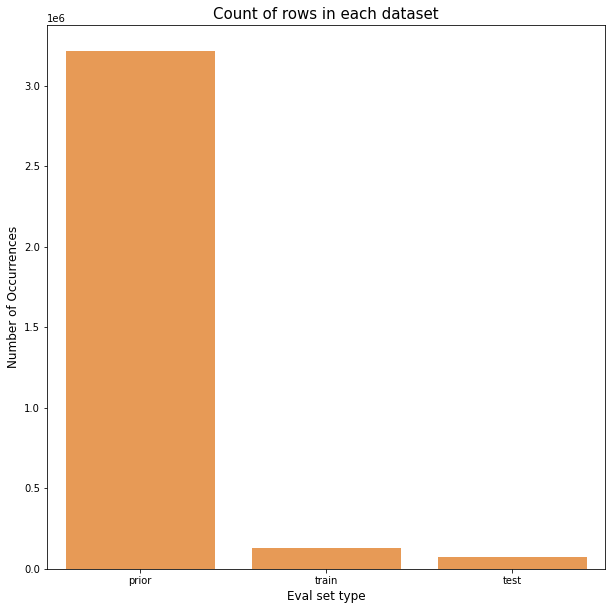

In [31]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize=(10,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

##### There are 206,209 customers in total. 
##### Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

In [32]:
cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

### There are no more than 4 to 100 orders of a customer

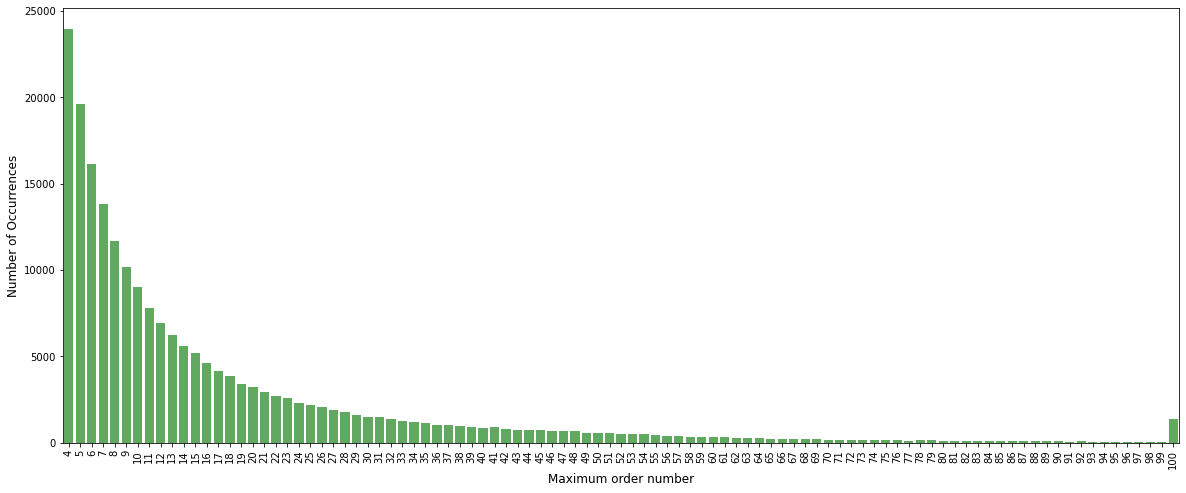

In [33]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Let us see how the ordering habit changes with day of week

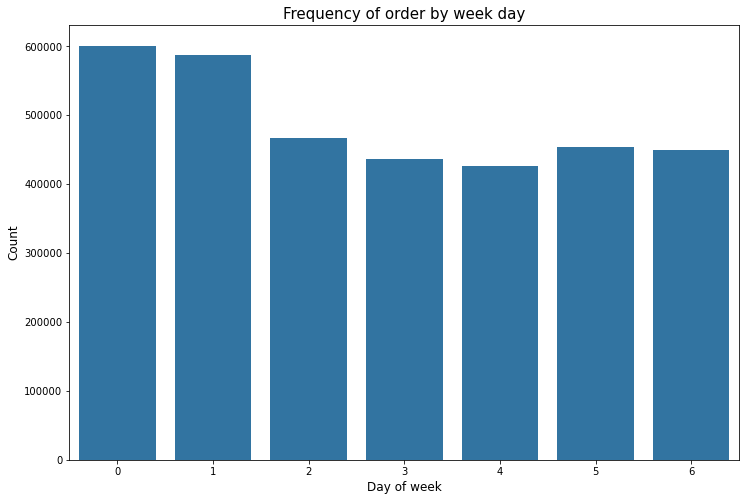

In [34]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='horizontal')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

##### Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday

### Now we shall see how the distribution is with respect to time of the day

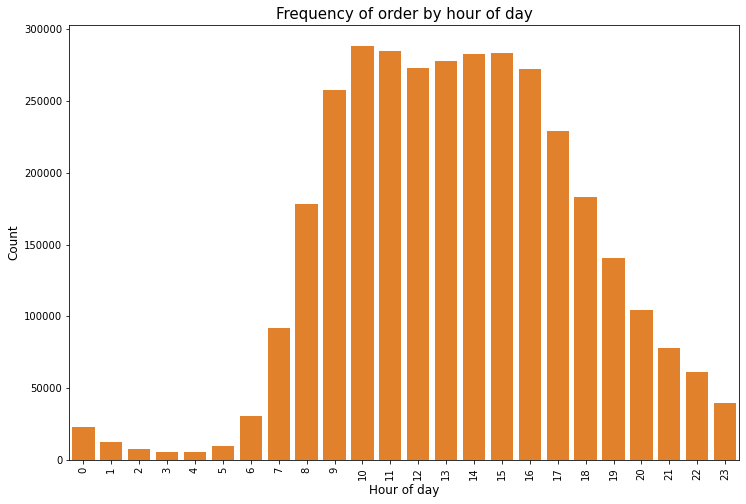

In [35]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

##### So majority of the orders are made during day time. 

### Now let us combine the day of week and hour of day to see the distribution

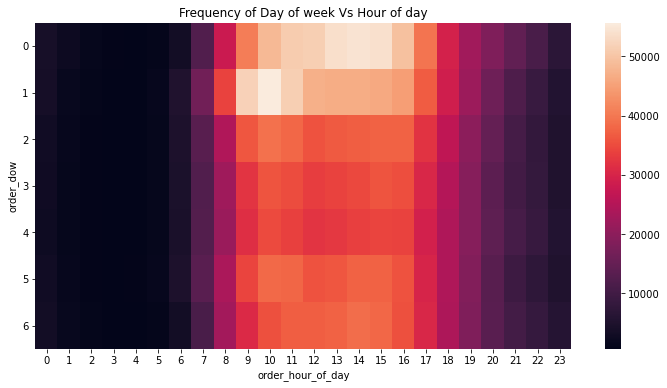

In [36]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.yticks(rotation='horizontal')
plt.show()

##### Seems Satuday evenings and Sunday mornings are the prime time for orders.

### Now let us check the time interval between the orders.

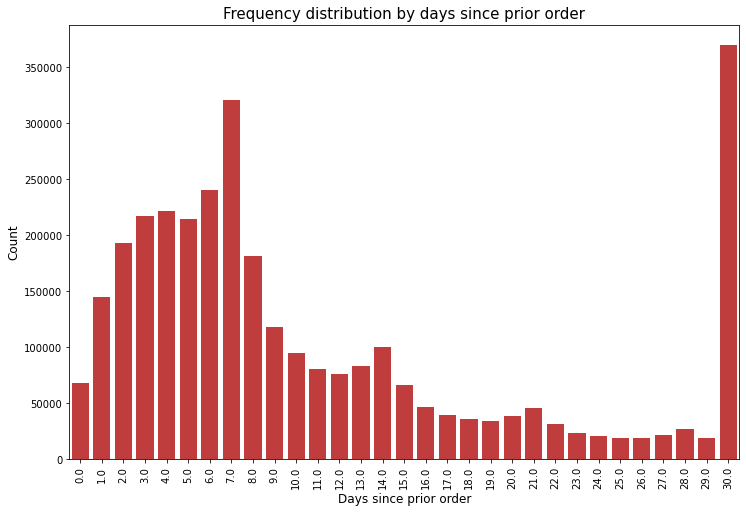

In [37]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

##### Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). 
      We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

### Now let us see the number of products bought in each order

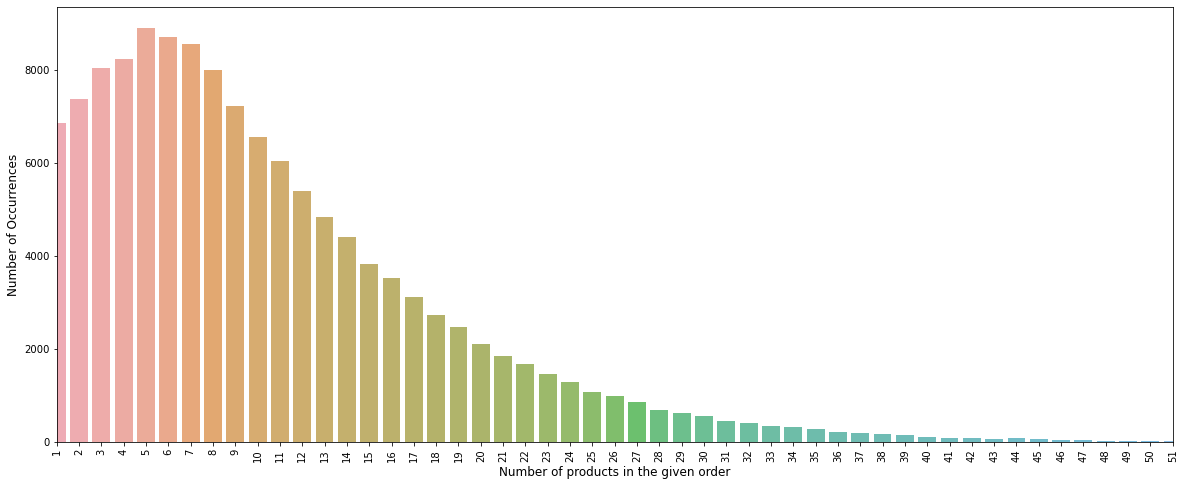

In [38]:
grouped_df = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.xlim([0, 50])
plt.show()

##### Most common order contains: 5 products

### Plot departments volume, split by aisles

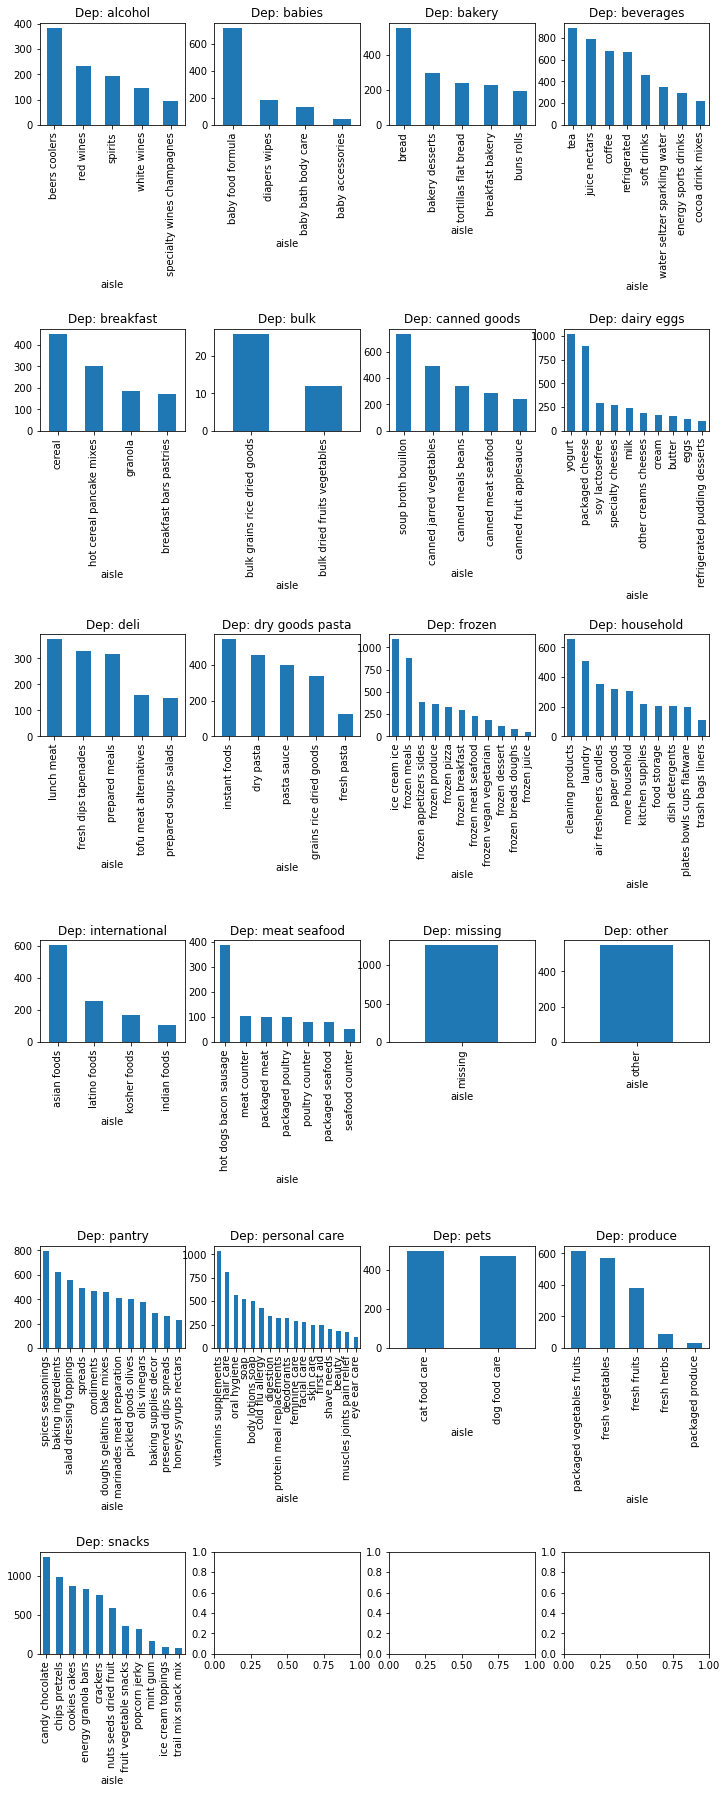

In [39]:
items.product_name = items.product_name.str.replace(' ', '_').str.lower() 

items.head()
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    items[items.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

#### Popular Products (Bestsellers)

In [40]:
cnt_srs = order_products_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


#### Graphically representation of Popular products

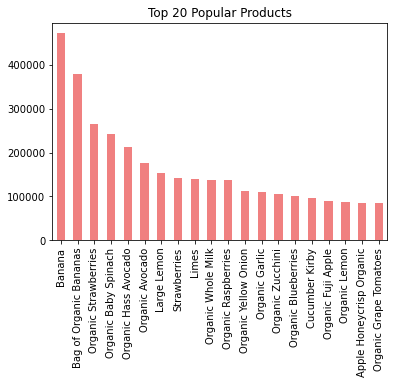

In [41]:
Products_Count = order_products_prior['product_name'].value_counts()
fig = plt.figure()
Products_Count[0:20].plot(kind="bar", color='lightcoral')
plt.xticks(rotation=90)
plt.title('Top 20 Popular Products')
plt.show()

##### Most of them are organic products.! Also majority of them are fruits.

In [42]:
products_tuple_list = [tuple(x) for x in Products_Count.reset_index().values]

In [43]:
dic = {}
for pair in products_tuple_list:
    key = pair[0]
#     print(type(key))
    value = pair[1]
#     print(type(value))
    if key in dic:
        reservedValue = dic[key]
        reservedValue += value 
    else:
        dic[key] = value

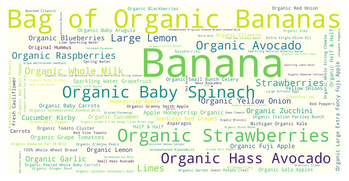

In [44]:
fig = plt.figure()
wordcloudData = WordCloud(width=4096,height=2048,
                          relative_scaling=1,
                          max_words = 100,
                          background_color='ivory').generate_from_frequencies(frequencies = dic)
plt.imshow(wordcloudData, interpolation='lanczos')
plt.axis("off")
plt.show()
fig.set_dpi(200)
fig.savefig('wordcloud.png',bbox_inches='tight')

In [45]:
products.head()

0       Organic Egg Whites
1    Michigan Organic Kale
2            Garlic Powder
3           Coconut Butter
4        Natural Sweetener
Name: product_name, dtype: object

### Now let us look at the important aisles.

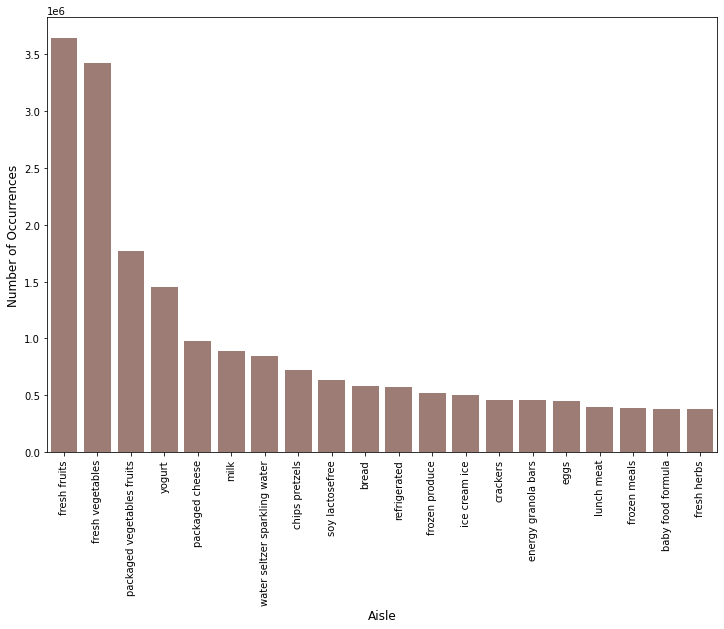

In [46]:
cnt_srs = order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

##### The top two aisles are fresh fruits and fresh vegetables.!

### Let us now check the department wise distribution.

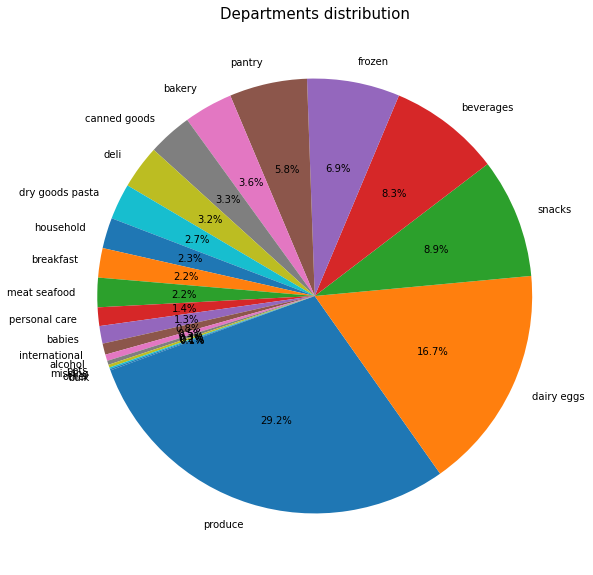

In [47]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

##### Produce is the largest department

### Product sold by lowest Volume Departments

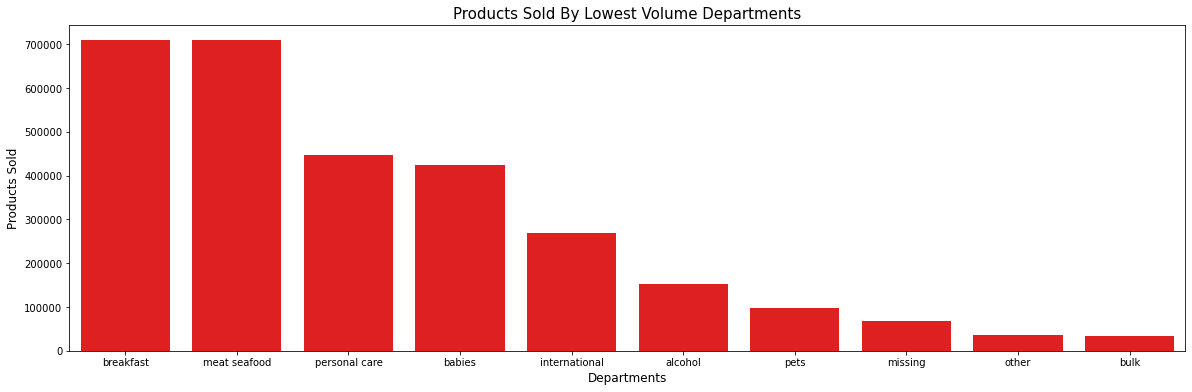

In [48]:
dept_infreq = order_products_prior['department'].value_counts().tail(10)
plt.figure(figsize=(20,6))
sns.barplot(dept_infreq.index, dept_infreq.values, color='red')
plt.ylabel('Products Sold', fontsize=12)
plt.xlabel('Departments', fontsize=12)
plt.title('Products Sold By Lowest Volume Departments', fontsize=15)
plt.show()

##### Bulk is the smallest department 

### % of Orders count of Organic and non-organic products

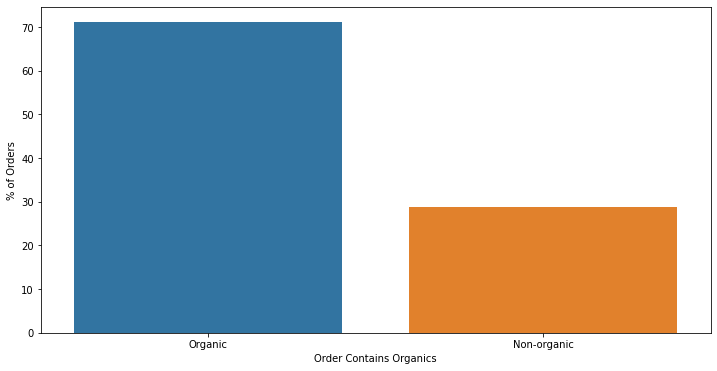

In [49]:
org = pd.merge(
    left=order_products_train[['product_id', 'order_id']],
    right=items[['product_id', 'product_name']],
    how='left',
    on='product_id')

org['organic'] = org.product_name.str.contains('organic').astype(np.int8)
org['organic'] = org['organic'].map({0: 'Non-organic', 1: 'Organic'})
org = org.groupby('order_id')['organic'].aggregate("max").value_counts()

# plot it
plt.figure(figsize=(12, 6))
sns.barplot(org.index, org / org.sum() * 100)
plt.xticks(rotation='horizontal')
plt.xlabel('Order Contains Organics')
plt.ylabel('% of Orders')
pass

# Since our objective is to figure out the re-orders

### Let us check out the re-order product percentage

### In prior set 

In [50]:
order_products_prior.reordered.sum() / order_products_prior.shape[0]

0.5896974667922161

### In train set

In [51]:
order_products_train.reordered.sum() / order_products_train.shape[0]

0.5985944127509629

##### On an average, about 59% of the products in an order are re-ordered products.

### Let us check out the No re-ordered products percentage

### In prior set

In [52]:
grouped_df = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df = grouped_df.reordered.value_counts() / grouped_df.shape[0]
grouped_df[0]

0.12084859313304347

### In train set

In [53]:
grouped_df = order_products_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df = grouped_df.reordered.value_counts() / grouped_df.shape[0]
grouped_df[0]

0.06555952716658156

##### About 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%.

### Most popular products that were reordered

In [54]:
temp_df = order_products_all.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

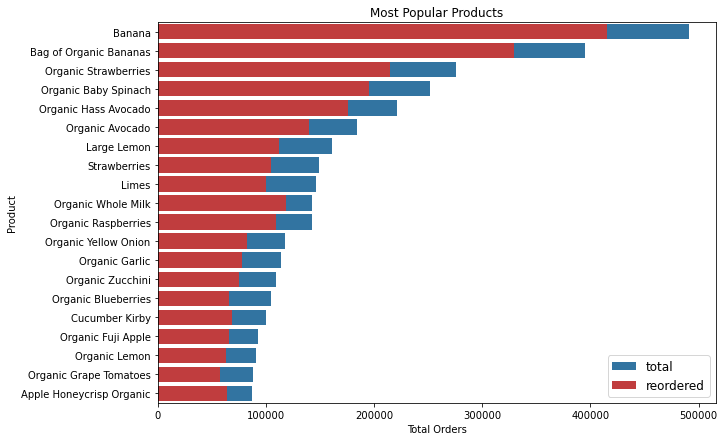

In [55]:
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Product")
ax.set_xlabel("Total Orders")
ax.set_title("Most Popular Products")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

### Department wise reorder ratio:

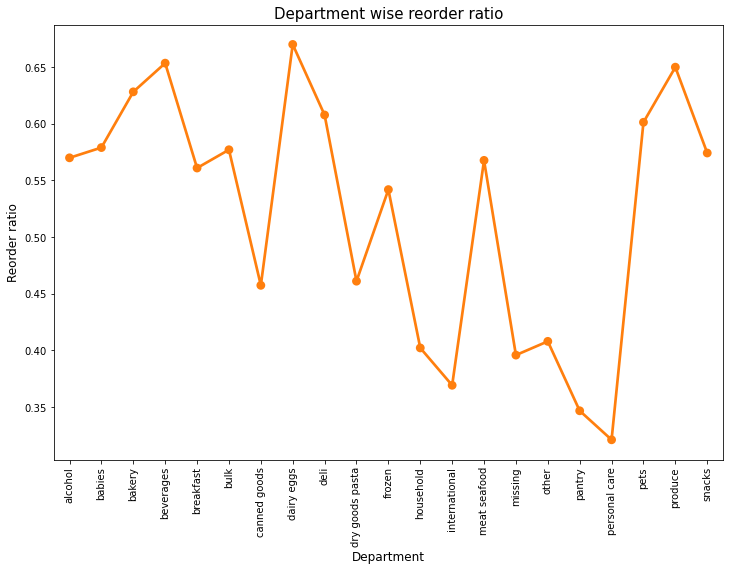

In [56]:
grouped_df = order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

#### Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.

### Total Orders and Reorders From Departments

In [57]:
temp_df = order_products_all.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

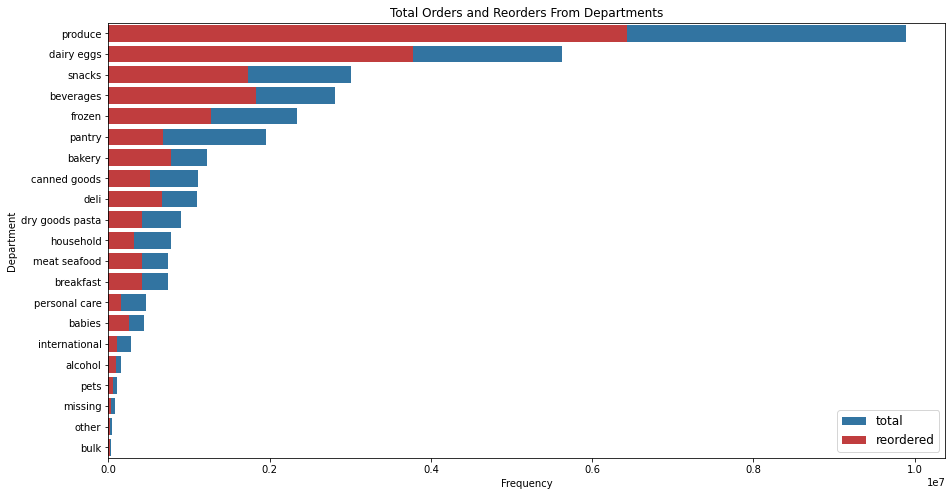

In [58]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.department, x = temp_df["total"], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.department, x = temp_df["reorders"], color=color[3], label = "reordered")
ax.set_ylabel("Department")
ax.set_xlabel("Frequency")
ax.legend(loc = 4, prop={'size': 12})
ax.set_title("Total Orders and Reorders From Departments")
plt.show()

### Aisle wise reorder ratio:

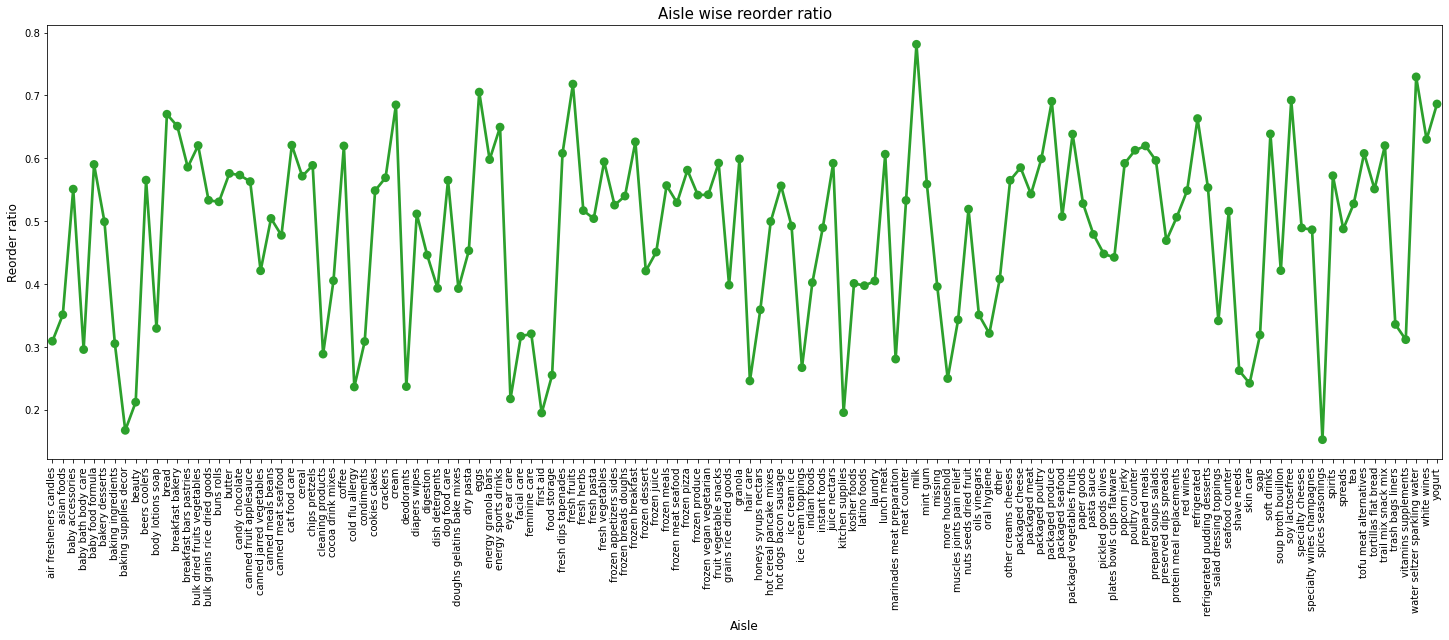

In [59]:
grouped_df = order_products_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()


plt.figure(figsize=(25,8))
sns.pointplot(grouped_df['aisle'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Aisle wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

#### Meat Counter have highest reorder ratio, while Spices seasonings has lowest reorder ratio 

### Total Orders and Reorders From Most Popular Aisles

In [60]:
temp_df = order_products_all.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

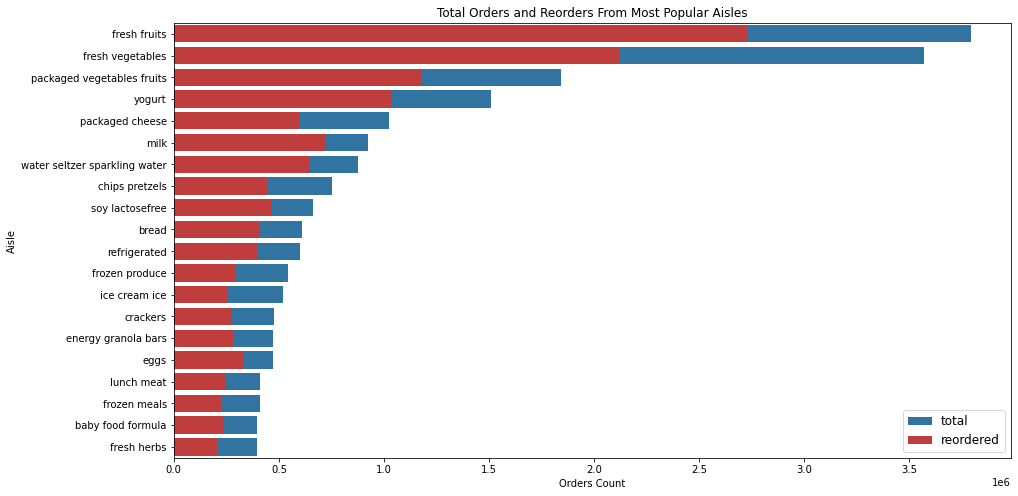

In [61]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Aisle")
ax.set_xlabel("Orders Count")
ax.set_title("Total Orders and Reorders From Most Popular Aisles")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

### Let us check the relationship between how order of adding the product to the cart affects the reorder ratio

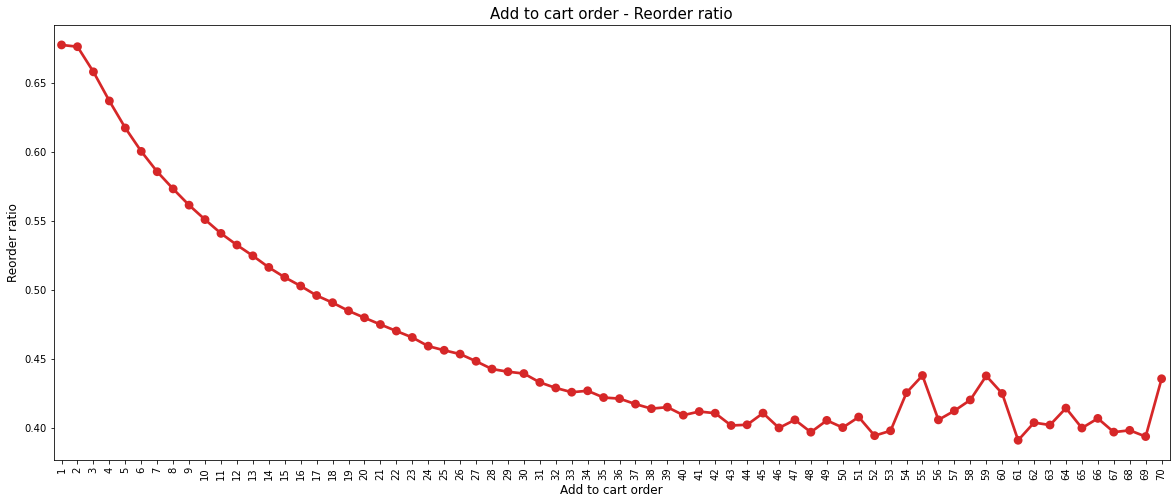

In [62]:
order_products_prior["add_to_cart_order_mod"] = order_products_prior["add_to_cart_order"].copy()
order_products_prior["add_to_cart_order_mod"].loc[order_products_prior["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

##### Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later. 
This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.

### Reorder ratio with day of week

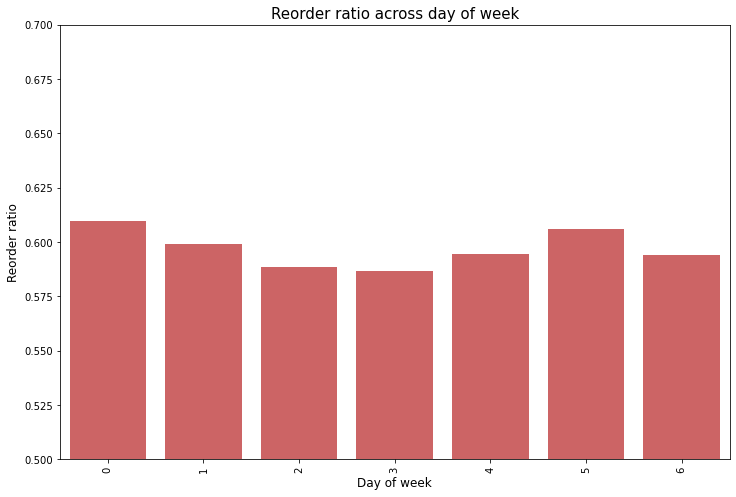

In [63]:
grouped_df = order_products_train.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

### Reorder ratio with respect to time of the day

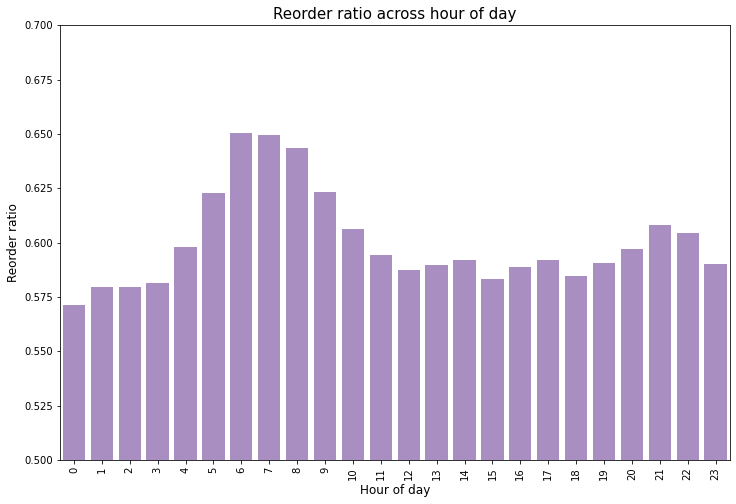

In [64]:
grouped_df = order_products_train.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

### Now let us combine Reordered data of the day of week and hour of day to see the distribution

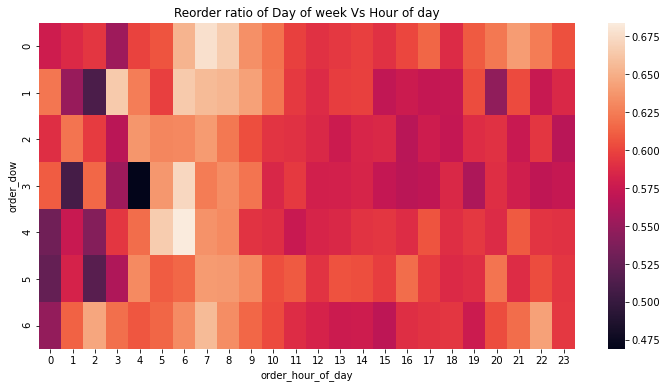

In [65]:
grouped_df = order_products_train.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

##### Looks like reorder ratios are quite high during the early mornings compared to later half of the day.

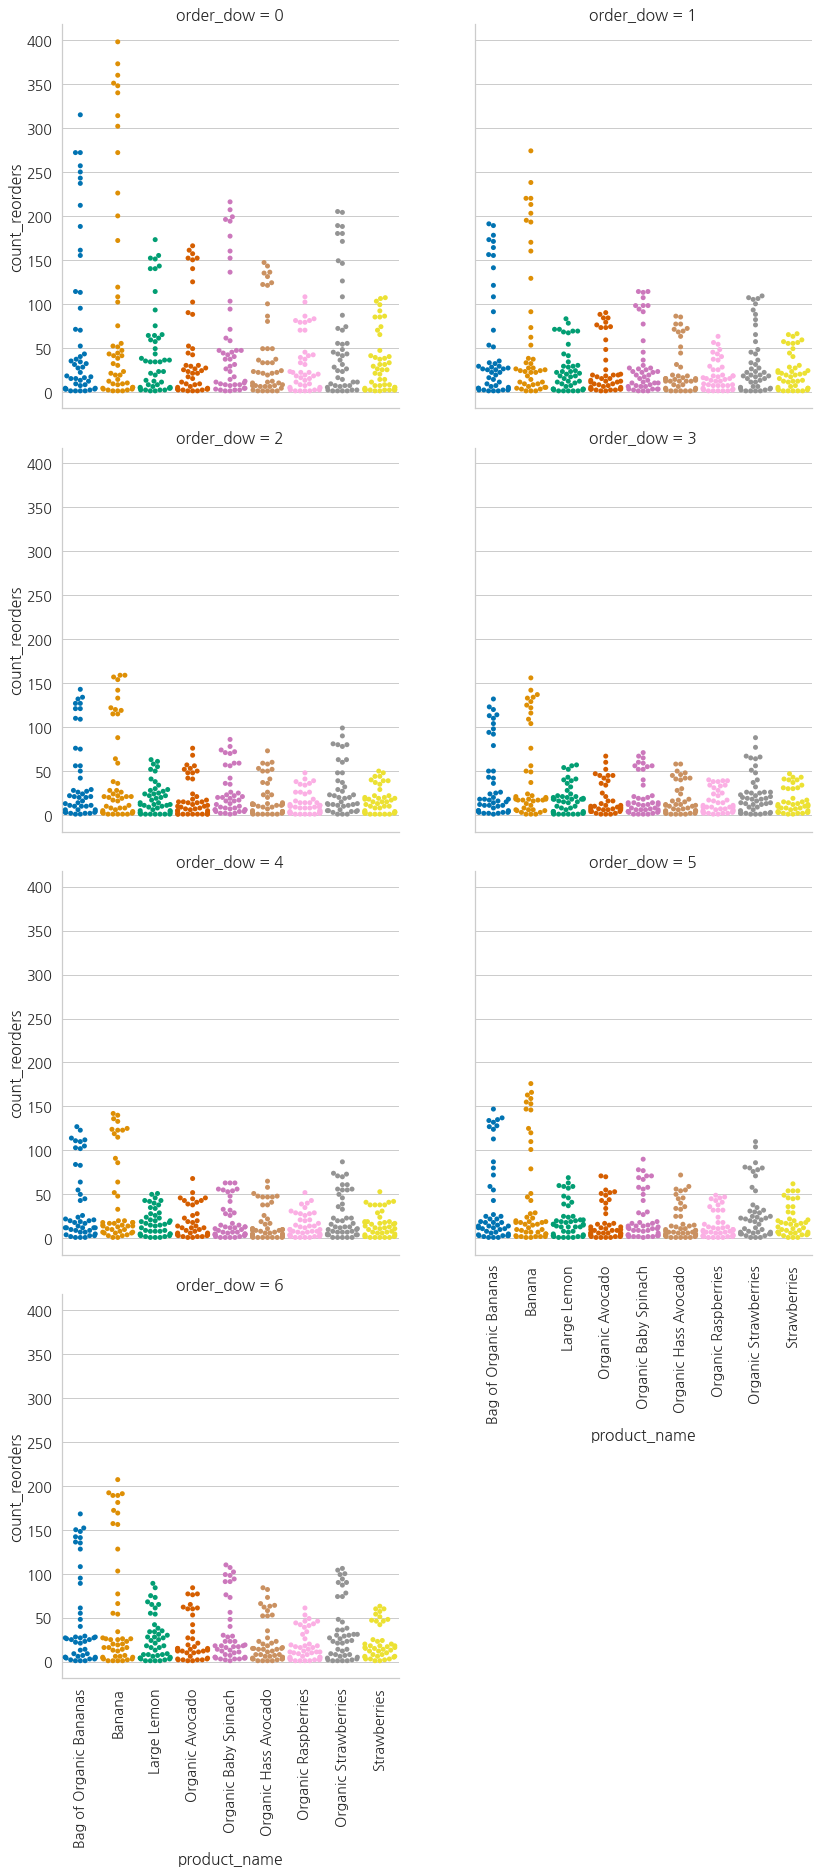

In [72]:
tmp_1_groupby= order_products_train.groupby(['order_dow','order_hour_of_day','product_name',
                                         'reordered']).agg({'order_id':
                                                            pd.Series.nunique}).rename(columns={'order_id':
                                                                                                'count_reorders'})
tmp_2_groupby = tmp_1_groupby['count_reorders'].groupby(level=0, group_keys=False)

tmp_8 = pd.DataFrame(tmp_1_groupby).reset_index()
tmp_9 = pd.DataFrame(tmp_2_groupby.nlargest(50)).reset_index()

top10_dayandtime = tmp_9[tmp_9['reordered']==1]


#Limit data to only those products which are in top 10 category by any time and day combination
tmp_8 = tmp_8[tmp_8['product_name'].isin(top10_dayandtime['product_name'])]


#temp_df_01 = temp_df_01[temp_df_01['day_of_week'].isin(['Monday','Tuesday'])] 

#Most orders are between 6 and 20
#temp_df_01 = temp_df_01[(temp_df_01['order_hour_of_day'] >= 6) & (temp_df_01['order_hour_of_day'] <= 20) ]

plt.close('all')
g = sns.factorplot(x='product_name', y='count_reorders',
                   #col="day_of_week", data=temp_df_01[temp_df_01['reordered']==1], kind="swarm",col_wrap=3,size=5);
                   col="order_dow", data=tmp_8, kind="swarm",col_wrap=2,size=6);
g.set_xticklabels(rotation=90)

# Using Linear models

## Predicting whether a product will be reordered or not

In [73]:
order_all = order_products_all.copy()
orders_new = orders[orders['days_since_prior_order'].notnull()]
order_all.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4,4,10,9.0,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4,4,10,9.0,canned meat seafood,canned goods


In [74]:
del order_all['eval_set']

In [75]:
del order_all['add_to_cart_order']

In [76]:
#Getting average days between orders as a feature by using days_since_prior_order
order_all['average_days_between_orders'] = orders_new.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
order_all['average_days_between_orders'] = order_all['average_days_between_orders'].replace(np.nan, 0)

In [77]:
order_all['average_days_between_orders'] = order_all['average_days_between_orders'].replace(0, 1)

In [78]:
#number of orders as a feature using the orders_new dataset
order_all['nb_orders'] = orders_new.groupby('user_id').size().astype(np.int16)
order_all['nb_orders'] = order_all['nb_orders'].replace(np.nan, 0)

In [79]:
train_order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


In [80]:
#Getting the total items using the entire dataset 
order_all['total_items'] = train_order_products.groupby('user_id').size().astype(np.int16)
order_all['total_items'] = order_all['total_items'].replace(np.nan, 0)

In [81]:
order_all.head()

,order_id,product_id,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department,average_days_between_orders,nb_orders,total_items
0,1,49302,1,Bulgarian Yogurt,120,16,112108,4,4,10,9.0,yogurt,dairy eggs,1.000000,0.0,0.0
1,1,11109,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,4,4,10,9.0,other creams cheeses,dairy eggs,19.000000,10.0,11.0
2,1,10246,0,Organic Celery Hearts,83,4,112108,4,4,10,9.0,fresh vegetables,produce,16.285715,14.0,31.0
3,1,49683,0,Cucumber Kirby,83,4,112108,4,4,10,9.0,fresh vegetables,produce,12.000000,12.0,0.0
4,1,43633,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,4,4,10,9.0,canned meat seafood,canned goods,17.000000,5.0,0.0


In [82]:
#calculating average basket
order_all['average_basket'] = (order_all.total_items /order_all.nb_orders).astype(np.float32)
order_all['average_basket'] = order_all['average_basket'].replace(np.nan, 0)

In [83]:
# Creating a days_since_ratio using days_since_prior_order and average_days_between_orders
order_all['days_since_ratio'] = order_all.days_since_prior_order / order_all.average_days_between_orders

In [84]:
order_all = order_all[order_all['days_since_ratio'].notnull()]

In [85]:
order_all.isnull().sum()

order_id                       0
product_id                     0
reordered                      0
product_name                   0
aisle_id                       0
department_id                  0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order         0
aisle                          0
department                     0
average_days_between_orders    0
nb_orders                      0
total_items                    0
average_basket                 0
days_since_ratio               0
dtype: int64

In [86]:
del order_all['user_id']

In [87]:
del order_all['product_name']

In [88]:
del order_all['department']

In [89]:
del order_all['aisle']

In [90]:
order_all.head()

,order_id,product_id,reordered,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,average_days_between_orders,nb_orders,total_items,average_basket,days_since_ratio
0,1,49302,1,120,16,4,4,10,9.0,1.000000,0.0,0.0,0.000000,9.000000
1,1,11109,1,108,16,4,4,10,9.0,19.000000,10.0,11.0,1.100000,0.473684
2,1,10246,0,83,4,4,4,10,9.0,16.285715,14.0,31.0,2.214286,0.552632
3,1,49683,0,83,4,4,4,10,9.0,12.000000,12.0,0.0,0.000000,0.750000
4,1,43633,1,95,15,4,4,10,9.0,17.000000,5.0,0.0,0.000000,0.529412


In [91]:
hour = {c:i for i,c in enumerate(order_all['order_hour_of_day'].unique())}
aisle = {c:i for i,c in enumerate(order_all['aisle_id'].unique())}
dept = {c:i for i,c in enumerate(order_all['department_id'].unique())}
product = {c:i for i,c in enumerate(order_all['product_id'].unique())}

In [92]:
order_all['aisle_new'] = [float(aisle[t]) for t in order_all.aisle_id]

order_all['days_since_prior_order'] = order_all['days_since_prior_order'].replace(np.nan, 0)


In [93]:
order_all['dept_new'] = [float(dept[t]) for t in order_all.department_id]
order_all['product_new'] = [float(product[t]) for t in order_all.product_id]
order_all['order_hour_of_day_new'] = [float(hour[t]) for t in order_all.order_hour_of_day]
order_all['order_hour_of_day_new'].value_counts()
dow = {c:i for i,c in enumerate(order_all['order_dow'].unique())}
order_all['order_dow_new'] = [float(dow[t]) for t in order_all.order_dow]
dspo = {c:i for i,c in enumerate(order_all['days_since_prior_order'].unique())}
order_all['days_since_prior_order__new'] = [float(dspo[t]) for t in order_all.days_since_prior_order]
order_all['reordered'] = order_all['reordered'].astype('float')

In [94]:
del order_all['aisle_id']
del order_all['department_id']
del order_all['order_hour_of_day']
del order_all['order_dow']
del order_all['days_since_prior_order']
del order_all['product_id']

In [95]:
#Variable to be predicted
y=order_all['reordered']

In [96]:
del order_all['reordered']

In [97]:
#final order_all which will be used to run our algorithms
order_all.head()

,order_id,order_number,average_days_between_orders,nb_orders,total_items,average_basket,days_since_ratio,aisle_new,dept_new,product_new,order_hour_of_day_new,order_dow_new,days_since_prior_order__new
0,1,4,1.000000,0.0,0.0,0.000000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4,19.000000,10.0,11.0,1.100000,0.473684,1.0,0.0,1.0,0.0,0.0,0.0
2,1,4,16.285715,14.0,31.0,2.214286,0.552632,2.0,1.0,2.0,0.0,0.0,0.0
3,1,4,12.000000,12.0,0.0,0.000000,0.750000,2.0,1.0,3.0,0.0,0.0,0.0
4,1,4,17.000000,5.0,0.0,0.000000,0.529412,3.0,2.0,4.0,0.0,0.0,0.0


In [98]:
from sklearn.model_selection import train_test_split

In [99]:
Xtr, Xtest, ytr, ytest = train_test_split(order_all, y, test_size=0.30, random_state=5)

In [100]:
Xtr.shape

(22218726, 13)

In [101]:
ytr=ytr.ravel()

In [102]:
ytest=ytest.ravel()

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [104]:
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

In [105]:
#fitting the model
clf.fit(Xtr, ytr)

LogisticRegression(C=0.02)

In [106]:
#predictions
pred=clf.predict(Xtest)

In [107]:
pred

array([0., 1., 1., ..., 1., 1., 1.])

In [108]:
#accuracy score of Logistic Regression Model
print(accuracy_score(clf.predict(Xtest), ytest))

0.6553216277727509


In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
#Random Forest model
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, 
                               oob_score=True)

In [111]:
#fitting
clfrf.fit(Xtr, ytr)

RandomForestClassifier(max_depth=11, max_features='log2',
                       min_samples_split=1000, n_estimators=24, oob_score=True)

In [112]:
#predictions
predrf=clfrf.predict(Xtest)

In [113]:
#accuracy score for the random forest model
accuracy_score(predrf, ytest)

0.7011939957438907

<AxesSubplot:>

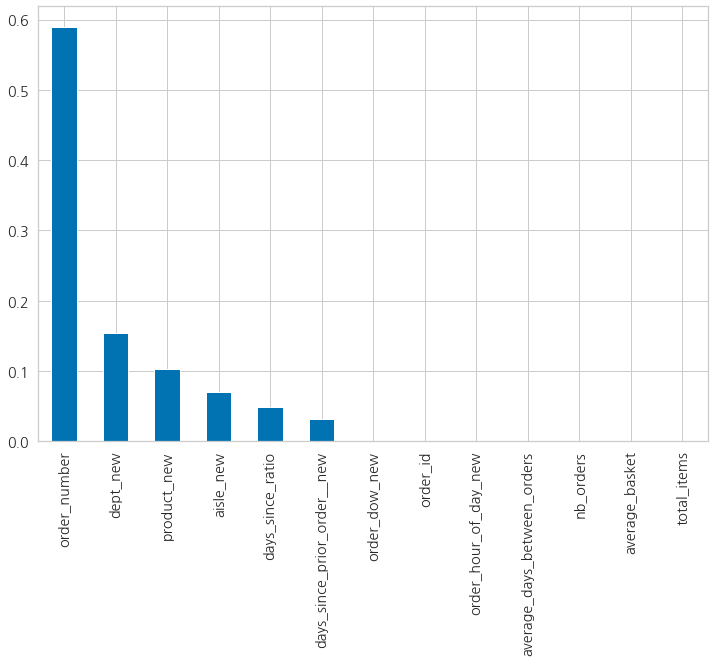

In [114]:
plt.figure(figsize=(12,8))
feature_imp_reordered = pd.Series(clfrf.feature_importances_,index= order_all.columns)
feature_imp_reordered.sort_values(ascending=False).plot(kind='bar')

### Looking at the feature_importances for predicting whether a product will be reoredered or not, the most important features turn out to be order_number, department, product, days since prior order and aisle

In [115]:
from sklearn.ensemble import AdaBoostClassifier

In [116]:
#AdaBoost Classifier
clfa = AdaBoostClassifier( n_estimators=24,random_state=True)

In [117]:
#fitting
clfa.fit(Xtr, ytr)

AdaBoostClassifier(n_estimators=24, random_state=True)

In [118]:
#predictions
preda = clfa.predict(Xtest)

In [119]:
#Accuracy Score for AdaBoost Classifier
accuracy_score(preda, ytest)

0.6921577448838055

In [120]:
from sklearn.ensemble import GradientBoostingClassifier

In [121]:
#Gradient Boosting Classifier
clfg= GradientBoostingClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000)

In [122]:
#fitting
clfg.fit(Xtr, ytr)

GradientBoostingClassifier(max_depth=11, max_features='log2',
                           min_samples_split=1000, n_estimators=24)

In [123]:
#predictions
predg = clfg.predict(Xtest)

In [124]:
#accuracy score for Gradient Boosting Classifier
accuracy_score(predg, ytest)

0.7066898249080685

## Predicting whether the Department will be reordered or not

In [125]:
order_all_new = order_products_all.copy()

In [126]:
# creating new features such as orders,
# reorders and reorder_rate for predicting the department variable

order_all_new['orders'] = order_all_new.groupby(order_all_new.product_id).size().astype(np.int32) 
order_all_new['orders'] = order_all_new['orders'].replace(np.nan,0)
order_all_new['reorders'] = order_all_new['reordered'].groupby(order_all_new.product_id).sum().astype(np.float32)
order_all_new['reorders'] = order_all_new['reorders'].replace(np.nan,0)
order_all_new['reorder_rate'] = (order_all_new.reorders / order_all_new.orders).astype(np.float32)
order_all_new['reorder_rate'] = order_all_new['reorder_rate'].replace(np.nan,0)

In [127]:
order_all_new['average_days_between_orders'] = orders_new.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
order_all_new['average_days_between_orders'] = order_all_new['average_days_between_orders'].replace(np.nan, 0)

In [128]:
order_all_new['average_days_between_orders'] = order_all_new['average_days_between_orders'].replace(0, 1)


In [129]:
order_all_new['nb_orders'] = orders_new.groupby('user_id').size().astype(np.int16)
order_all_new['nb_orders'] = order_all_new['nb_orders'].replace(np.nan, 0)

In [130]:
#Getting the total items using the entire dataset 
order_all_new['total_items'] = train_order_products.groupby('user_id').size().astype(np.int16)
order_all_new['total_items'] = order_all_new['total_items'].replace(np.nan, 0)

In [131]:
order_all_new['average_basket'] = (order_all_new.total_items /order_all_new.nb_orders).astype(np.float32)

In [132]:
order_all_new['average_basket'] = order_all_new['average_basket'].replace(np.nan, 0)

In [133]:
order_all_new['days_since_ratio'] = order_all_new.days_since_prior_order / order_all_new.average_days_between_orders

In [134]:
order_all_new['order_hour_of_day_new'] = [float(hour[t]) for t in order_all_new.order_hour_of_day]

In [135]:
order_all_new['reordered'] = order_all_new['reordered'].astype('float')

In [136]:
order_all_new['order_dow_new'] = [float(dow[t]) for t in order_all_new.order_dow]

In [137]:
order_all_new = order_all_new[order_all_new['days_since_prior_order'].notnull()]

In [138]:
order_all_new['days_since_prior_order__new'] = [float(dspo[t]) for t in order_all_new.days_since_prior_order]

In [139]:
order_all_new['dept_new'] = [float(dept[t]) for t in order_all_new.department_id]

In [140]:
order_all_new['product_new'] = [float(product[t]) for t in order_all_new.product_id]

In [141]:
del order_all_new['days_since_prior_order']
del order_all_new['order_dow']
del order_all_new['order_hour_of_day']
del order_all_new['department_id']
del order_all_new['aisle_id']
del order_all_new['product_id']
del order_all_new['add_to_cart_order']
del order_all_new['eval_set']
del order_all_new['department']
del order_all_new['product_name']
del order_all_new['product_new']

In [142]:
# display order_all_new
order_all_new.head()

,order_id,reordered,user_id,order_number,aisle,orders,reorders,reorder_rate,average_days_between_orders,nb_orders,total_items,average_basket,days_since_ratio,order_hour_of_day_new,order_dow_new,days_since_prior_order__new,dept_new
0,1,1.0,112108,4,yogurt,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,9.000000,0.0,0.0,0.0,0.0
1,1,1.0,112108,4,other creams cheeses,1928.0,1185.0,0.614627,19.000000,10.0,11.0,1.100000,0.473684,0.0,0.0,0.0,0.0
2,1,0.0,112108,4,fresh vegetables,94.0,13.0,0.138298,16.285715,14.0,31.0,2.214286,0.552632,0.0,0.0,0.0,1.0
3,1,0.0,112108,4,fresh vegetables,283.0,209.0,0.738516,12.000000,12.0,0.0,0.000000,0.750000,0.0,0.0,0.0,1.0
4,1,1.0,112108,4,canned meat seafood,351.0,161.0,0.458689,17.000000,5.0,0.0,0.000000,0.529412,0.0,0.0,0.0,2.0


In [143]:
# our variable to be predicted
ynew = order_all_new['dept_new']

In [144]:
del order_all_new['dept_new']

In [145]:
del order_all_new['aisle']

In [146]:
Xtrnew, Xtestnew, ytrnew, ytestnew = train_test_split(order_all_new, ynew, test_size=0.30, random_state=5)
# Random Forest classifier
clfrfnew = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, 
                               oob_score=True)

In [147]:
# fitting
clfrfnew.fit(Xtrnew, ytrnew)

RandomForestClassifier(max_depth=11, max_features='log2',
                       min_samples_split=1000, n_estimators=24, oob_score=True)

In [148]:
# predictions and probabilities
predrfnewp =clfrfnew.predict_proba(Xtestnew)

<AxesSubplot:>

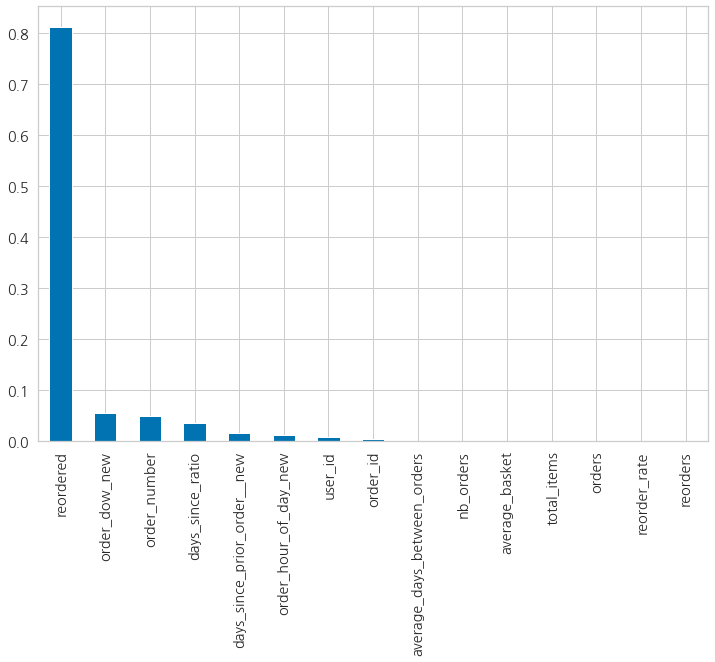

In [149]:
plt.figure(figsize=(12,8))
feature_imp_dept = pd.Series(clfrfnew.feature_importances_,index= order_all_new.columns)
feature_imp_dept.sort_values(ascending=False).plot(kind='bar')

### The most important features while predicting the department are: Reordered, day of week, order number, user_id and order_id.



In [150]:
# Log loss for the Random Forest model
log_loss( ytestnew,predrfnewp)

2.3211866035162876

In [ ]:
# Gradient Boosting Classifier
clfgb= GradientBoostingClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000)

In [ ]:
# fitting
clfgb.fit(Xtrnew,ytrnew)

In [ ]:
# predictions and probabilties
predgbnewp =clfgb.predict_proba(Xtestnew)

In [ ]:
# Log loss score for Gradient Boosting Classifier
log_loss( ytestnew,predgbnewp)

In [ ]:
# AdaBoost Classifier
clfada = AdaBoostClassifier( n_estimators=24,random_state=True)

In [ ]:
# fitting
clfada.fit(Xtrnew, ytrnew)

In [ ]:
# predictions and probabilities
predadap = clfada.predict_proba(Xtestnew)

In [ ]:
# Log loss score for AdaBoost Classifier
log_loss( ytestnew,predadap)

###### The best model for predicting whether a product will be reorodered or not is the Gradient Boosting Classifier with 70.6 accuracy. Whereas while predicting the category of the department, Random Forest Classifier is the best model with a log loss score of 2.321.

# Implemenation of Apyori

In [32]:
# make a copy of orders to use later on
orders_apriori = orders.copy()

##### Take small subset for configuration

In [33]:
# create transaction dataframe
transactions_df = order_products_prior[['order_id', 'product_id']][:5000]

In [34]:
# obtain number of order and products
n_orders = len(set(transactions_df.order_id))
n_products = len(set(transactions_df.product_id))
print(n_orders, n_products)

499 2809


There are 499 orders and 2,809 in the chosen subset

##### Calculating Product frequency

In [35]:
# obtain frequency of items and assign it to product_frequency
product_frequency = transactions_df.product_id.value_counts()/n_orders
min(product_frequency), max(product_frequency)

(0.002004008016032064, 0.1402805611222445)

### Plot product_frequency vs number of times

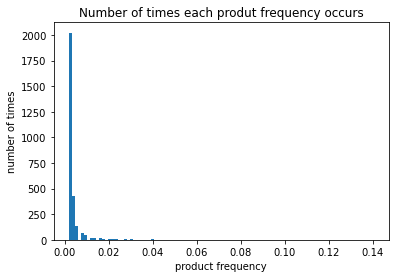

In [36]:
plt.hist(product_frequency, bins = 100);
plt.title('Number of times each produt frequency occurs');
plt.xlabel('product frequency');
plt.ylabel('number of times');

In order to avoid including the products purchased only rarely, I will here set the minimum support equal to 0.01, which stands for the products bought at least 4 times. I will then filter the products that fit this threshold to a new dataframe.

In [37]:
# filter products by number of frequency with a minimum support of 0.01
min_support = 0.01
products_apriori = product_frequency[product_frequency >= min_support]
print(products_apriori)

24852    0.140281
13176    0.120240
21903    0.078156
21137    0.064128
47209    0.064128
           ...   
12276    0.010020
35503    0.010020
31343    0.010020
40332    0.010020
41658    0.010020
Name: product_id, Length: 149, dtype: float64


There are 149 products remaining. In this example, it means a 95% reduction in the relevant data amount, which will clearly make computations easier.



#### Get a new transactions dataframe containing only these products.

In [38]:
# after obtaining the new transaction, it is assigned to transactions_apriori
transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
print(transactions_apriori)

      order_id  product_id
0            2       33120
1            2       28985
5            2       17794
10           3       24838
12           3       21903
...        ...         ...
4975       526        1940
4982       527       49235
4988       527       21903
4989       527       35939
4992       527       17461

[1429 rows x 2 columns]


The transactions were reduced from 5,000 to 1,429 (71%).

### Plot data by number of times each order size occurs

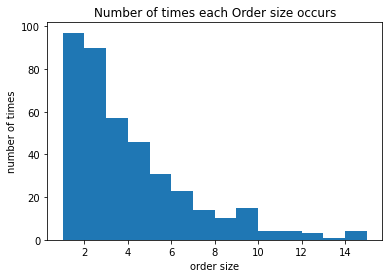

In [39]:
order_sizes = transactions_apriori.order_id.value_counts()
plt.hist(order_sizes, bins = max(order_sizes) - min(order_sizes));
plt.title('Number of times each Order size occurs');
plt.xlabel('order size');
plt.ylabel('number of times');

This tells me that most orders have 1 or 2 products. Since it makes no sense to make association rules with only 1 product, I can discard them. Then, I can also here establish the minimum length of the itemsets to be considered. If I set this value to, say, 4, it also makes no sense to include the orders with 3 products or less.

##### For this implementation, I will set the minimum length equals to 2.


In [40]:
min_length = 2
orders_apriori = order_sizes[order_sizes >= min_length]
print(orders_apriori)

431    15
493    15
265    14
426    14
359    13
       ..
211     2
196     2
208     2
436     2
293     2
Name: order_id, Length: 302, dtype: int64


There are 302 orders left (reduction of 39%).


In [41]:
# transactions_apriori contains the order id by index
transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
print(transactions_apriori)

      order_id  product_id
0            2       33120
1            2       28985
5            2       17794
10           3       24838
12           3       21903
...        ...         ...
4975       526        1940
4982       527       49235
4988       527       21903
4989       527       35939
4992       527       17461

[1332 rows x 2 columns]


There are 1,332 transactions left (73% reduction from the initial dataset).

##### Making all possible combinations inside each order

In [43]:

'''
    Group purchases by order id, followed by retrieving the order list
    that contains the variable product id.
    This will allow generate all possible combninations of each order
    by limiting it to 2
'''


transactions_by_order = transactions_apriori.groupby('order_id')['product_id']
for order_id, order_list in transactions_by_order:
    product_combinations = combinations(order_list, 2)
    if(order_id < 5):
        print('Order_id:', order_id, '\nOrder_list: ', list(order_list))
        print('Product combinations:')
        print([i for i in product_combinations])
        print('\n')

Order_id: 2 
Order_list:  [33120, 28985, 17794]
Product combinations:
[(33120, 28985), (33120, 17794), (28985, 17794)]


Order_id: 3 
Order_list:  [24838, 21903, 46667, 17461]
Product combinations:
[(24838, 21903), (24838, 46667), (24838, 17461), (21903, 46667), (21903, 17461), (46667, 17461)]




Let me explain, what happended in order id :3.
This order contains 4 products, printed above. With these 4 products, there are 6 possible combinations, also printed.



##### Concatenate all combinations from all order, then count the number of occurences.

In [44]:
# This function will combine products and count the number of occurances
def product_combinations(transactions_df, max_length = 5):
    transactions_by_order = transactions_df.groupby('order_id')['product_id']
    max_length_reference = max_length
    
    #iterate through transactions by order for order id and order list
    for order_id, order_list in transactions_by_order:
        max_length = min(max_length_reference, len(order_list))
        order_list = sorted(order_list)
        
        # now we can make the product combination by using the max_length
        # and order_list that was sorted
        for l in range(2, max_length + 1):
            product_combinations = combinations(order_list, l)
            for combination in product_combinations:
                yield combination

We can call an element of the generator by first instantiating it, then casting it to an iterator, then finally calling the next element.

### Display the generated product combination for each iteration

In [45]:
combs = product_combinations(transactions_apriori)
next(iter(combs))

(17794, 28985)

This is the very first combination generated based on the transactions_apriori dataframe.

The beauty of generators is that, differently from regular functions, they keep track of their internal state, so that, if I call the next function again, it will spit out the second combination.

In [46]:
next(iter(combs))

(17794, 33120)

And repeating it 100 more times.

In [47]:
for _ in range(100):
    print(next(iter(combs)))

(28985, 33120)
(17794, 28985, 33120)
(17461, 21903)
(17461, 24838)
(17461, 46667)
(21903, 24838)
(21903, 46667)
(24838, 46667)
(17461, 21903, 24838)
(17461, 21903, 46667)
(17461, 24838, 46667)
(21903, 24838, 46667)
(17461, 21903, 24838, 46667)
(6184, 13176)
(6184, 23909)
(6184, 27966)
(6184, 37011)
(6184, 47209)
(13176, 23909)
(13176, 27966)
(13176, 37011)
(13176, 47209)
(23909, 27966)
(23909, 37011)
(23909, 47209)
(27966, 37011)
(27966, 47209)
(37011, 47209)
(6184, 13176, 23909)
(6184, 13176, 27966)
(6184, 13176, 37011)
(6184, 13176, 47209)
(6184, 23909, 27966)
(6184, 23909, 37011)
(6184, 23909, 47209)
(6184, 27966, 37011)
(6184, 27966, 47209)
(6184, 37011, 47209)
(13176, 23909, 27966)
(13176, 23909, 37011)
(13176, 23909, 47209)
(13176, 27966, 37011)
(13176, 27966, 47209)
(13176, 37011, 47209)
(23909, 27966, 37011)
(23909, 27966, 47209)
(23909, 37011, 47209)
(27966, 37011, 47209)
(6184, 13176, 23909, 27966)
(6184, 13176, 23909, 37011)
(6184, 13176, 23909, 47209)
(6184, 13176, 27966, 3

#### observation:
From looking at the data above we can determine that different products have anything between 2-5 combinations due to the max_length = 5

##### Counting all combinations occurrences

In [48]:
# Now we will count the product combinations to find the frequency they appear
# and then we will show some of the results
combs = product_combinations(transactions_apriori)
# using the items  function will return the count in tuple 
# form which is what we want
counter = Counter(combs).items() 
combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter]) # the first element in the tuple is the count, the second is the combination
combinations_frequency = combinations_count / n_orders

#print the frequency
print(combinations_frequency)

(17794, 28985)                  0.006012
(17794, 33120)                  0.002004
(28985, 33120)                  0.002004
(17794, 28985, 33120)           0.002004
(17461, 21903)                  0.004008
                                  ...   
(17461, 21903, 35939)           0.002004
(17461, 21903, 49235)           0.002004
(17461, 35939, 49235)           0.002004
(21903, 35939, 49235)           0.002004
(17461, 21903, 35939, 49235)    0.002004
Length: 41452, dtype: float64


##### There you have it! From those 1,332 transactions, we got 41,452 possible combinations with the parameters set above.

In [49]:
min(combinations_frequency), max(combinations_frequency)

(0.002004008016032064, 0.028056112224448898)

##### That means the least common combinations appear in 0.002 * 499 = 1 order, and the most common appear in 0.028 * 499 = 14 orders.


##### To comply with the algorithm, the combinations must also be filtered according to the min_support and min_length criteria.

In [50]:
# Now we filter even more the combinations through minimum support
# and minimum length 
combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]

#print the product combination
print(combinations_apriori, len(combinations_apriori))

(13176, 27966)    0.018036
(13176, 47209)    0.018036
(27966, 47209)    0.012024
(21137, 24852)    0.014028
(21137, 47766)    0.012024
(24852, 47766)    0.012024
(21903, 24852)    0.028056
(13176, 17794)    0.010020
(13176, 43352)    0.010020
(21903, 22935)    0.010020
(16797, 39275)    0.012024
(16797, 43352)    0.010020
(24852, 49683)    0.012024
(24852, 47626)    0.014028
(37646, 47209)    0.012024
(21903, 47209)    0.012024
(21137, 21903)    0.010020
(21137, 47209)    0.010020
(13176, 22935)    0.014028
(24852, 28204)    0.016032
(24852, 45066)    0.016032
(1158, 21903)     0.010020
(9076, 24852)     0.014028
(16797, 24852)    0.010020
(13176, 21137)    0.014028
(24852, 26209)    0.014028
(12341, 16797)    0.010020
dtype: float64 27


### Deriving the rules

In [53]:
A = []
B = []
AB = []
for c in combinations_apriori.index:
    c_length = len(c) 
    '''
        obtain all possible combinations from 1 to c length elements - 1
        this will allow A to get a new combination of at least 1 element
        and leaving array B to have a maximum of 2 elements
    '''
    for l in range(1, c_length):
        comb = combinations(c, l)
        for a in comb:
            AB.append(c)
            b = list(c)
            for e in a:
                b.remove(e)
            b = tuple(b)
            if len(a) == 1:
                a = a[0]
            A.append(a)
            if len(b) == 1:
                b = b[0]
            B.append(b)

apriori_df = pd.DataFrame({'A': A,
                           'B': B,
                           'AB': AB})
apriori_df.head()

    '''
        get each element's support from the previously calculated supports
        by creating a dictionary which will contain all the elements
        with their respective supports
    '''
support = {**{k: v for k, v in products_apriori.items()}, 
           **{k: v for k, v in combinations_frequency.items()}}

apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])

apriori_df.drop('AB', axis = 1, inplace = True)

apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A

apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B

    '''
        Apply the last filter for minimum confidence and lift
    '''

# filter the apriori dataframe by minimum confidence and minimum lift
min_confidence = 0.2
min_lift = 1.0
apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
apriori_df = apriori_df[apriori_df.lift >= min_lift]

# sort apriori dataframe by lift
apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)



### Converting the product_ids to product_names

In [54]:
# converts product id to the appropiate name for easier reading
def convert_product_id_to_name(product_ids):
    # return result if produt_ids is equal to int
    if type(product_ids) == int:
        return products_id_to_name[product_ids]
    
    # if it not equal to int then we go through product_ids
    # and return the names
    names = []
    for prod in product_ids:
        name = products_id_to_name[prod]
        names.append(name)
    names = tuple(names)
    return names

In [56]:
# get the names of each product id and populate it in the columns
# A and B in order to understand the data better

products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}
apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)
apriori_df

,A,B,support_A,support_B,support_AB,confidence,lift
0,Hass Avocados,Strawberries,0.018036,0.058116,0.010020,0.555556,9.559387
1,Mango Chunks,Organic Baby Spinach,0.014028,0.078156,0.010020,0.714286,9.139194
2,Organic Gala Apples,Organic Hass Avocado,0.022044,0.064128,0.012024,0.545455,8.505682
3,Strawberries,Organic Blueberries,0.058116,0.028056,0.012024,0.206897,7.374384
4,Organic Blueberries,Strawberries,0.028056,0.058116,0.012024,0.428571,7.374384
5,Raspberries,Strawberries,0.030060,0.058116,0.010020,0.333333,5.735632
6,Organic Raspberries,Organic Hass Avocado,0.040080,0.064128,0.012024,0.300000,4.678125
7,Blueberries,Banana,0.022044,0.140281,0.014028,0.636364,4.536364
8,Organic Avocado,Organic Strawberries,0.048096,0.064128,0.012024,0.250000,3.898438
9,Organic Fuji Apple,Banana,0.030060,0.140281,0.016032,0.533333,3.801905


##### These are the results of the subsets of data that we have considered to build the pipeline

In [57]:
# association_rules will return the apriori dataframe
def association_rules(order_products, min_support, min_length = 2, max_length = 5, min_confidence = 0.2, min_lift = 1.0):
    
    print('Loading data...')
    #load data set to be able to calculate supports and combinations late on
    transactions_df = order_products[['order_id', 'product_id']]

    print('Calculating product supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    # get order size and then filter it through the minimum length
    # this is done in order to get the product supports
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Calculating product combinations and supports...')
    
    # this function will combine products based on the apriori method
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        
        # Loop through transactions by order
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            
            # iteration needed to obtain the combination product from order_list
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                
                # loop thorugh product_combination to get each combination
                for combination in product_combinations:
                    yield combination
   
    # count combination frequency and filters the combination 
    # through minimum support and minimum length just like we have done it before
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Populating dataframe...')
    # implement similar coding used previously
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    # this function will convert the product id to
    # it's actual name for easier reading
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    # apply converted product id function to apriori dataframe
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print('{} rules were generated'.format(len(apriori_df)))

    # return final dataframe
    return apriori_df

### Testing the function on whole dataset with min_support = 0.01

In [59]:
start = datetime.now()
rules = association_rules(order_products_all, min_support = 0.01)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
11 rules were generated
Execution time:  0:04:53.685637


### Display Association Rules with min_support = 0.01

In [60]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042618,0.082358,0.010619,0.249174,3.025499
1,Organic Fuji Apple,Banana,0.027761,0.146826,0.010506,0.378441,2.577484
2,Organic Raspberries,Bag of Organic Bananas,0.042618,0.118028,0.012637,0.296508,2.512197
3,Organic Hass Avocado,Bag of Organic Bananas,0.066011,0.118028,0.019354,0.293199,2.484160
4,Organic Avocado,Banana,0.055057,0.146826,0.016620,0.301866,2.055949
5,Organic Strawberries,Bag of Organic Bananas,0.082358,0.118028,0.019337,0.234787,1.989259
6,Strawberries,Banana,0.044663,0.146826,0.012905,0.288936,1.967882
7,Large Lemon,Banana,0.048054,0.146826,0.012862,0.267663,1.822995
8,Organic Baby Spinach,Bag of Organic Bananas,0.075224,0.118028,0.015722,0.209007,1.770829
9,Organic Baby Spinach,Banana,0.075224,0.146826,0.015957,0.212133,1.444796


With a minimum support of 0.01, the strongest relationship is between organic raspberries and organic strawberries. 25% of users who buy raspberries do also buy strawberries. All other association rules with these criteria involve some produce and bananas. The largest confidence, 38%, is between fuji apple and banana. The lift is not so high though, ranging from 1.4 to 2.6.

It is also noteworthy that, even though the rules output combinations of the most commonly purchased products, their support is lower than 0.02. That means that all other combinations of two products will be present in less than 2% of all orders. Combinations of three or more will more much rarer.

### Testing the function on whole dataset with min_support = 0.005 and max_length = 4

In [62]:
start = datetime.now()
rules = association_rules(order_products_all, min_support = 0.005, max_length = 4)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
37 rules were generated
Execution time:  0:08:43.555931


### Display Association Rules with min_support = 0.005 and max_length = 4

In [63]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Cilantro,Limes,0.021831,0.043830,0.005550,0.254237,5.800474
1,Organic Garlic,Organic Yellow Onion,0.034051,0.035180,0.006851,0.201192,5.718889
2,Organic Lemon,Organic Hass Avocado,0.027271,0.066011,0.006583,0.241389,3.656823
3,Organic Cucumber,Organic Hass Avocado,0.025404,0.066011,0.005465,0.215129,3.258999
4,Organic Raspberries,Organic Strawberries,0.042618,0.082358,0.010619,0.249174,3.025499
5,Organic Blueberries,Organic Strawberries,0.031388,0.082358,0.007479,0.238274,2.893150
6,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023328,0.118028,0.007273,0.311789,2.641663
7,Organic Fuji Apple,Banana,0.027761,0.146826,0.010506,0.378441,2.577484
8,Organic Raspberries,Bag of Organic Bananas,0.042618,0.118028,0.012637,0.296508,2.512197
9,Organic Cucumber,Organic Strawberries,0.025404,0.082358,0.005256,0.206894,2.512124


We see some other produce combined with banana, as well as milk and banana. The are some lifts higher than 5, for cilantro and lime, and garlic and onion. The higher confidence, 38%, is that of fuji apple and banana.

### Testing the function on whole dataset with min_support = 0.002 and max_length = 3

In [65]:
start = datetime.now()
rules = association_rules(order_products_all, min_support = 0.002, max_length = 3)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
218 rules were generated
Execution time:  0:08:42.820736


### Display Association Rules with min_support = 0.002 and max_length= 3

In [66]:
rules.head(20)

,A,B,support_A,support_B,support_AB,confidence,lift
0,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005966,0.005067,0.002225,0.372909,73.602482
1,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005067,0.005966,0.002225,0.439096,73.602482
2,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,0.005966,0.005648,0.002045,0.342851,60.702117
3,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005648,0.005966,0.002045,0.362136,60.702117
4,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt With Blu...,0.009225,0.006397,0.002859,0.309888,48.442450
5,Total 2% Lowfat Greek Strained Yogurt With Blu...,Total 2% with Strawberry Lowfat Greek Strained...,0.006397,0.009225,0.002859,0.446858,48.442450
6,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained...,0.006142,0.009225,0.002463,0.400983,43.469253
7,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt with Peach,0.009225,0.006142,0.002463,0.266993,43.469253
8,Organic Whole Strawberries,Frozen Organic Wild Blueberries,0.009760,0.009256,0.002096,0.214802,23.207780
9,Frozen Organic Wild Blueberries,Organic Whole Strawberries,0.009256,0.009760,0.002096,0.226510,23.207780


With a minimum support of 0.002, 211 rules were generated. I am inspecting only the first 20.

The strongest association (lift 73) is between blueberry and raspberry non-fat yoghurt, followed by other paired flavors of yoghurt (lift 43-61). The highest confidence (45%) is also revolving yoghurts. Next, there are paired berries and peppers, then flavored sparkling water. Following, I notice what seems to be ingredientes for guacamole.

### Testing the function on whole dataset with min_support = 0.001 and max_length = 2

In [68]:
start = datetime.now()
rules = association_rules(order_products_all, min_support = 0.001, max_length = 2)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
400 rules were generated
Execution time:  0:03:07.744236


### Display Association Rules with min_support = 0.001 and max_length = 2

In [69]:
rules.head(20)

,A,B,support_A,support_B,support_AB,confidence,lift
0,Non Fat Acai & Mixed Berries Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.002714,0.005966,0.001224,0.450782,75.561227
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Acai & Mixed Berries Yogurt,0.005966,0.002714,0.001224,0.205090,75.561227
2,Lemon Sparkling Water,Grapefruit Sparkling Water,0.002975,0.004650,0.001040,0.349438,75.154066
3,Grapefruit Sparkling Water,Lemon Sparkling Water,0.004650,0.002975,0.001040,0.223615,75.154066
4,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005067,0.005966,0.002225,0.439096,73.602482
5,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005966,0.005067,0.002225,0.372909,73.602482
6,Nonfat Icelandic Style Strawberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.003295,0.005966,0.001408,0.427392,71.640621
7,Icelandic Style Skyr Blueberry Non-fat Yogurt,Nonfat Icelandic Style Strawberry Yogurt,0.005966,0.003295,0.001408,0.236048,71.640621
8,Nonfat Icelandic Style Strawberry Yogurt,Non Fat Raspberry Yogurt,0.003295,0.005067,0.001180,0.358095,70.678723
9,Non Fat Raspberry Yogurt,Nonfat Icelandic Style Strawberry Yogurt,0.005067,0.003295,0.001180,0.232879,70.678723


Finally, with a minimum support of 0.001 and a maximum length of 2,394 rules were returned. From the top 20, the relationship between yoghurt types and some kinds of sparkling water is reinforced. Lifts are as high as 76, and the confidence is up to 45%. I suspect users tend to purchase more than one flavor at once, opting for diverse tastes. If the retailer was willing to promote a new yoghurt product, they could sell it promotionally along another youghurt product.

### Apriori Conclusion: 

The model shows a very consistent relationship between the different types of yoghurts as shown by the confidence given by the algorithm because consumers tend to go for different flavors that are similar to the ones they buy.

This could help the retailer to use this to their advantage when selling a new type of yoghurt by promotioning it with another flavor similar to it. This also falls into the sparkling water item falvors

# Implemenation of FP-Growth

### Loading libraries

In [71]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import collect_set, col, count
from pyspark.ml.fpm import FPGrowth
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

In [72]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Define SparkSession

In [73]:
sc = SparkContext('local')
spark = SparkSession(sc)

### Creating Dataframes

In [74]:
# Import Data
aisles = spark.read.csv("aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv("order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv("orders.csv", header=True, inferSchema=True)
products = spark.read.csv("products.csv", header=True, inferSchema=True)

# Create Temporary Tables
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

### Create a baskets data frame before feeding into the algorithm

In [75]:
'''
    create basket df contains order id and the items in it
'''
rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets_pandas_df = baskets.toPandas()
baskets_pandas_df.head(10)

,order_id,items
0,1342,"[Raw Shrimp, Seedless Cucumbers, Versatile Stain Remover, Organic Strawberries, Organic Mandarins, Chicken Apple Sausage, Pink Lady Apples, Bag of Organic Bananas]"
1,1591,"[Cracked Wheat, Strawberry Rhubarb Yoghurt, Organic Bunny Fruit Snacks Berry Patch, Goodness Grapeness Organic Juice Drink, Honey Graham Snacks, Spinach, Granny Smith Apples, Oven Roasted Turkey Breast, Pure Vanilla Extract, Chewy 25% Low Sugar Chocolate Chip Granola, Banana, Original Turkey Burgers Smoke Flavor Added, Twisted Tropical Tango Organic Juice Drink, Navel Oranges, Lower Sugar Instant Oatmeal Variety, Ultra Thin Sliced Provolone Cheese, Natural Vanilla Ice Cream, Cinnamon Multigrain Cereal, Garlic, Goldfish Pretzel Baked Snack Crackers, Original Whole Grain Chips, Medium Scarlet Raspberries, Lemon Yogurt, Original Patties (100965) 12 Oz Breakfast, Nutty Bars, Strawberry Banana Smoothie, Green Machine Juice Smoothie, Coconut Dreams Cookies, Buttermilk Waffles, Uncured Genoa Salami, Organic Greek Whole Milk Blended Vanilla Bean Yogurt]"
2,4519,[Beet Apple Carrot Lemon Ginger Organic Cold Pressed Juice Beverage]
3,4935,[Vodka]
4,6357,"[Globe Eggplant, Panko Bread Crumbs, Fresh Mozzarella Ball, Grated Parmesan, Gala Apples, Italian Pasta Sauce Basilico Tomato, Basil & Garlic, Organic Basil, Banana, Provolone]"
5,10362,"[Organic Baby Spinach, Organic Spring Mix, Organic Leek, Slow Roasted Lightly Seasoned Chick'n, Organic Basil, Organic Shredded Mild Cheddar, Bag of Organic Bananas, Sliced Baby Bella Mushrooms, Organic Tapioca Flour, Organic Gala Apples, Lemons, Limes, Pitted Dates, Jalapeno Peppers, Original Tofurky Deli Slices, Organic Red Bell Pepper, Organic Shredded Carrots, Roma Tomato, Crinkle Cut French Fries, Large Greenhouse Tomato, Organic Pinto Beans, Organic Three Grain Tempeh, Organic Garnet Sweet Potato (Yam), Organic Coconut Milk, Organic Extra Firm Tofu, Ground Sausage Style Veggie Protein, Extra Virgin Olive Oil, Hass Avocados, Multigrain Tortilla Chips, The Ultimate Beefless Burger, Yellow Bell Pepper, Coconut Flour, Light Brown Sugar, Organic Harissa Seasoning, Crushed Garlic, Organic Whole Cashews]"
6,19204,"[Reduced Fat Crackers, Dishwasher Cleaner, Peanut Powder, Disinfecting Wipes Lemon & Fresh Scent, Lemon Lime Thirst Quencher, Fat Free & Lower Sodium Chicken Broth, American Blend Salad, Cinnamon Cereal, Extra Nasal Strips, Reduced Fat Creamy Peanut Butter Spread, Mozzarella String Cheese Sticks, Light Low-Moisture Part Skim, Electrolyte Enhanced Water, Original Petroleum Jelly, High Efficiency Complete Dual Formula]"
7,29601,"[Organic Red Onion, Small Batch Authentic Taqueria Tortilla Chips, Hummus, Hope, Original Recipe, Unsweetened Whole Milk Peach Greek Yogurt, Toasted Coconut Almondmilk Blend, Skillet Refried Red Beans Sautéed With Onion & Tomatillo, Almondmilk, Pure, Chocolate Protein, Organic Greek Lowfat Yogurt With Strawberries, Bag of Organic Bananas, California Orange Juice, Mini Whole Wheat Pita Bread, Coconut Almond Creamer Blend, Banana Chia Pod, Tomatillo Salsa, SALSA FRNTR CHPTL SALSA, Guacamole, Water]"
8,31035,"[Organic Cripps Pink Apples, Organic Golden Delicious Apple, Organic Navel Orange, Bag of Organic Bananas]"
9,40011,"[Organic Baby Spinach, Organic Blues Bread with Blue Cornmeal Crust, Sea Salt Macadamias, Natural Calm Magnesium Supplement Raspberry Lemon Flavor Powder, Chocolate Coconut Protein Bar, Sport Chocolate Mint Protein Bar]"


In [76]:
print((baskets.count(), len(baskets.columns)))

(131209, 2)


In [77]:
# get items from basket and display the first 10 of the dataframe
items = spark.sql("select items from baskets").toDF("items")
items_pandas_df = items.toPandas()
items_pandas_df.head(10)

,items
0,"[Raw Shrimp, Seedless Cucumbers, Versatile Stain Remover, Organic Strawberries, Organic Mandarins, Chicken Apple Sausage, Pink Lady Apples, Bag of Organic Bananas]"
1,"[Cracked Wheat, Strawberry Rhubarb Yoghurt, Organic Bunny Fruit Snacks Berry Patch, Goodness Grapeness Organic Juice Drink, Honey Graham Snacks, Spinach, Granny Smith Apples, Oven Roasted Turkey Breast, Pure Vanilla Extract, Chewy 25% Low Sugar Chocolate Chip Granola, Banana, Original Turkey Burgers Smoke Flavor Added, Twisted Tropical Tango Organic Juice Drink, Navel Oranges, Lower Sugar Instant Oatmeal Variety, Ultra Thin Sliced Provolone Cheese, Natural Vanilla Ice Cream, Cinnamon Multigrain Cereal, Garlic, Goldfish Pretzel Baked Snack Crackers, Original Whole Grain Chips, Medium Scarlet Raspberries, Lemon Yogurt, Original Patties (100965) 12 Oz Breakfast, Nutty Bars, Strawberry Banana Smoothie, Green Machine Juice Smoothie, Coconut Dreams Cookies, Buttermilk Waffles, Uncured Genoa Salami, Organic Greek Whole Milk Blended Vanilla Bean Yogurt]"
2,[Beet Apple Carrot Lemon Ginger Organic Cold Pressed Juice Beverage]
3,[Vodka]
4,"[Globe Eggplant, Panko Bread Crumbs, Fresh Mozzarella Ball, Grated Parmesan, Gala Apples, Italian Pasta Sauce Basilico Tomato, Basil & Garlic, Organic Basil, Banana, Provolone]"
5,"[Organic Baby Spinach, Organic Spring Mix, Organic Leek, Slow Roasted Lightly Seasoned Chick'n, Organic Basil, Organic Shredded Mild Cheddar, Bag of Organic Bananas, Sliced Baby Bella Mushrooms, Organic Tapioca Flour, Organic Gala Apples, Lemons, Limes, Pitted Dates, Jalapeno Peppers, Original Tofurky Deli Slices, Organic Red Bell Pepper, Organic Shredded Carrots, Roma Tomato, Crinkle Cut French Fries, Large Greenhouse Tomato, Organic Pinto Beans, Organic Three Grain Tempeh, Organic Garnet Sweet Potato (Yam), Organic Coconut Milk, Organic Extra Firm Tofu, Ground Sausage Style Veggie Protein, Extra Virgin Olive Oil, Hass Avocados, Multigrain Tortilla Chips, The Ultimate Beefless Burger, Yellow Bell Pepper, Coconut Flour, Light Brown Sugar, Organic Harissa Seasoning, Crushed Garlic, Organic Whole Cashews]"
6,"[Reduced Fat Crackers, Dishwasher Cleaner, Peanut Powder, Disinfecting Wipes Lemon & Fresh Scent, Lemon Lime Thirst Quencher, Fat Free & Lower Sodium Chicken Broth, American Blend Salad, Cinnamon Cereal, Extra Nasal Strips, Reduced Fat Creamy Peanut Butter Spread, Mozzarella String Cheese Sticks, Light Low-Moisture Part Skim, Electrolyte Enhanced Water, Original Petroleum Jelly, High Efficiency Complete Dual Formula]"
7,"[Organic Red Onion, Small Batch Authentic Taqueria Tortilla Chips, Hummus, Hope, Original Recipe, Unsweetened Whole Milk Peach Greek Yogurt, Toasted Coconut Almondmilk Blend, Skillet Refried Red Beans Sautéed With Onion & Tomatillo, Almondmilk, Pure, Chocolate Protein, Organic Greek Lowfat Yogurt With Strawberries, Bag of Organic Bananas, California Orange Juice, Mini Whole Wheat Pita Bread, Coconut Almond Creamer Blend, Banana Chia Pod, Tomatillo Salsa, SALSA FRNTR CHPTL SALSA, Guacamole, Water]"
8,"[Organic Cripps Pink Apples, Organic Golden Delicious Apple, Organic Navel Orange, Bag of Organic Bananas]"
9,"[Organic Baby Spinach, Organic Blues Bread with Blue Cornmeal Crust, Sea Salt Macadamias, Natural Calm Magnesium Supplement Raspberry Lemon Flavor Powder, Chocolate Coconut Protein Bar, Sport Chocolate Mint Protein Bar]"


### Training the model

In [78]:
fpGrowth = FPGrowth(itemsCol ='items', minSupport=0.001, minConfidence=0, numPartitions=10)
model = fpGrowth.fit(baskets)

using the FPGrowth method we are putting a treshhold of 0.001 as minimum support. This is to narrow down the frequency of baskets by a minimum of 131. This is obtain: minSupport * basketCount

### Display most Frequent Items in the Basket

In [79]:
# Display most frequent item sets from the basket
mostFrequentItems = model.freqItemsets
mostFrequentItems.createOrReplaceTempView("mostFrequentItems")
displayMostFrequentItems = spark.sql("select items, freq from mostFrequentItems where size(items) > 2 order by freq desc")
displayMostFrequentItems_pandas_df = displayMostFrequentItems.toPandas()
displayMostFrequentItems_pandas_df.head()

,items,freq
0,"[Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas]",710
1,"[Organic Raspberries, Organic Strawberries, Bag of Organic Bananas]",649
2,"[Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas]",587
3,"[Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas]",531
4,"[Organic Hass Avocado, Organic Baby Spinach, Bag of Organic Bananas]",497


We can observe that there are common items in the top 5 baskets purchased by costumers such as Organic Has Avocado, Bag of Organic Bananas, Organic Strawberries, and Organic Raspberries

This table also allows us to use the frequency bought item in order to use it in the recommendation algorithm

### Generating Association Rule Mining 

###### Predicting what a costumer bought (antecedent), then we can recommend what the user will purchase next (consequent)

In [80]:
associationFrequency = model.associationRules
associationFrequency.createOrReplaceTempView("associationFrequency")
displayAssociationFrequency = spark.sql("SELECT antecedent AS `antecedent (if)`, consequent AS `consequent (then)`, confidence, lift FROM associationFrequency ORDER BY confidence DESC")
displayAssociationFrequency_pandas_df = displayAssociationFrequency.toPandas()
displayAssociationFrequency_pandas_df.head(20)
print('Execution time: ', datetime.now() - start)

,antecedent (if),consequent (then),confidence,lift
0,"[Organic Raspberries, Organic Hass Avocado, Organic Strawberries]",[Bag of Organic Bananas],0.598425,5.072272
1,"[Organic Cucumber, Organic Hass Avocado, Organic Strawberries]",[Bag of Organic Bananas],0.546875,4.635331
2,"[Organic Kiwi, Organic Hass Avocado]",[Bag of Organic Bananas],0.545977,4.627719
3,"[Organic Navel Orange, Organic Raspberries]",[Bag of Organic Bananas],0.541219,4.587387
4,"[Yellow Onions, Strawberries]",[Banana],0.535714,3.753633
5,"[Organic Whole String Cheese, Organic Hass Avocado]",[Bag of Organic Bananas],0.531469,4.504745
6,"[Organic Navel Orange, Organic Hass Avocado]",[Bag of Organic Bananas],0.528302,4.477905
7,"[Organic Raspberries, Organic Hass Avocado]",[Bag of Organic Bananas],0.521099,4.416854
8,"[Organic D'Anjou Pears, Organic Hass Avocado]",[Bag of Organic Bananas],0.517045,4.382495
9,"[Organic Unsweetened Almond Milk, Organic Hass Avocado]",[Bag of Organic Bananas],0.514107,4.357585


As shown in the above table with a high confidence of 0.52+, the model can recommend the purchase of organic bananas to anyone that has in their basket organic raspberries, organic avocados, and organic strawberries

###### Predicting what a costumer bought (antecedent), then we can recommend what the user will purchase next (consequent)

In [81]:
associationFrequency = model.associationRules
associationFrequency.createOrReplaceTempView("associationFrequency")
displayAssociationFrequency = spark.sql("SELECT antecedent AS `antecedent (if)`, consequent AS `consequent (then)`, confidence, lift FROM associationFrequency ORDER BY lift DESC")
displayAssociationFrequency_pandas_df = displayAssociationFrequency.toPandas()
displayAssociationFrequency_pandas_df.head(20)
print('Execution time: ', datetime.now() - start)

,antecedent (if),consequent (then),confidence,lift
0,[Strawberry Rhubarb Yoghurt],[Blueberry Yoghurt],0.309665,80.298014
1,[Blueberry Yoghurt],[Strawberry Rhubarb Yoghurt],0.310277,80.298014
2,[Icelandic Style Skyr Blueberry Non-fat Yogurt],[Nonfat Icelandic Style Strawberry Yogurt],0.217021,78.660621
3,[Nonfat Icelandic Style Strawberry Yogurt],[Icelandic Style Skyr Blueberry Non-fat Yogurt],0.422652,78.660621
4,[Icelandic Style Skyr Blueberry Non-fat Yogurt],[Non Fat Acai & Mixed Berries Yogurt],0.239716,74.887947
5,[Non Fat Acai & Mixed Berries Yogurt],[Icelandic Style Skyr Blueberry Non-fat Yogurt],0.402381,74.887947
6,[Blackberry Cucumber Sparkling Water],[Kiwi Sandia Sparkling Water],0.256757,72.449026
7,[Kiwi Sandia Sparkling Water],[Blackberry Cucumber Sparkling Water],0.286022,72.449026
8,[Non Fat Raspberry Yogurt],[Icelandic Style Skyr Blueberry Non-fat Yogurt],0.381944,71.084466
9,[Icelandic Style Skyr Blueberry Non-fat Yogurt],[Non Fat Raspberry Yogurt],0.312057,71.084466


Looking at the data displayed above we can see that what was previously bought by a costumer has a high possibility of purhcasing the consequent product.

For example, if a costumer buys "Blueberry Yoghurt" the predicted item to be bought next is "Strawberry Rhubarb Yoghurt" and the model has a 0.31 confidence that it will be selected by the costumer

This allows to display recommended items in pairs to the product due to the relationship between items driving higher sales and better user experience

##### Displaying actual items purchased vs predicted items

In [82]:
prediction = model.transform(baskets)
prediction.createOrReplaceTempView("prediction")
displayPrediction = spark.sql("SELECT order_id, items, prediction FROM prediction")
displayPrediction_pandas_df = displayPrediction.toPandas()
displayPrediction_pandas_df.head(5)

,order_id,items,prediction
0,1342,"[Raw Shrimp, Seedless Cucumbers, Versatile Stain Remover, Organic Strawberries, Organic Mandarins, Chicken Apple Sausage, Pink Lady Apples, Bag of Organic Bananas]","[Organic Basil, Organic Banana, Hass Avocado, Yellow Onions, Organic Broccoli Crowns, Organic Garnet Sweet Potato (Yam), Organic D'Anjou Pears, Organic Blueberries, Organic Old Fashioned Rolled Oats, Organic Russet Potato, Extra Virgin Olive Oil, Organic Bartlett Pear, Unsweetened Original Almond Breeze Almond Milk, Organic Baby Arugula, Organic Bosc Pear, Organic Sticks Low Moisture Part Skim Mozzarella String Cheese, Medium Navel Orange, Organic Roasted Turkey Breast, Organic Tomato Cluster, Organic Kiwi, Organic Whole Milk, Organic Thompson Seedless Raisins, Total 2% with Strawberry Lowfat Greek Strained Yogurt, Uncured Hickory Smoked Sunday Bacon, Feta Cheese Crumbles, Yellow Bell Pepper, Red Peppers, Organic Ginger Root, Organic Coconut Milk, Organic Black Beans, Organic Baby Carrots, Organic Roma Tomato, Blueberries, Roasted Turkey Breast, Green Beans, Organic Large Extra Fancy Fuji Apple, Organic Whole String Cheese, Banana, Organic Red Radish, Bunch, Organic Milk, Honeycrisp Apple, 100% Whole Wheat Bread, Whipped Cream Cheese, Orange Bell Pepper, Organic Hothouse Cucumbers, Organic Cucumber, Green Bell Pepper, Organic Unsalted Butter, Organic Reduced Fat 2% Milk, Organic Cilantro, Honey Nut Cheerios, Hass Avocados, Pineapple Chunks, Sparkling Natural Mineral Water, Organic Zucchini, Shredded Parmesan, Carrots, Baked Aged White Cheddar Rice and Corn Puffs, Organic Shredded Carrots, Organic Mint, Organic Romaine Lettuce, Organic Navel Orange, Ground Turkey Breast, Air Chilled Organic Boneless Skinless Chicken Breasts, Organic Baby Spinach, Unsalted Butter, Original Hummus, Shredded Mild Cheddar Cheese, Organic Baby Rainbow Carrots, 100% Raw Coconut Water, Blackberries, Organic Peeled Whole Baby Carrots, Uncured Genoa Salami, Organic Yellow Onion, Organic Romaine, Lime Sparkling Water, Total Greek Strained Yogurt, Large Lemon, Organic Blackberries, Watermelon Chunks, Cantaloupe, Organic Creamy Peanut Butter, Apple Honeycrisp Organic, Grape White/Green Seedless, Organic Lemon, Original Veggie Straws, Russet Potato, Organic Gala Apples, Organic American Cheese Singles, Roma Tomato, Organic Avocado, Organic Whole Strawberries, Red Vine Tomato, Sparkling Water Grapefruit, Fresh Ginger Root, Half & Half, Frozen Organic Wild Blueberries, Organic Grade A Free Range Large Brown Eggs, Organic Garlic, Red Raspberries, ...]"
1,1591,"[Cracked Wheat, Strawberry Rhubarb Yoghurt, Organic Bunny Fruit Snacks Berry Patch, Goodness Grapeness Organic Juice Drink, Honey Graham Snacks, Spinach, Granny Smith Apples, Oven Roasted Turkey Breast, Pure Vanilla Extract, Chewy 25% Low Sugar Chocolate Chip Granola, Banana, Original Turkey Burgers Smoke Flavor Added, Twisted Tropical Tango Organic Juice Drink, Navel Oranges, Lower Sugar Instant Oatmeal Variety, Ultra Thin Sliced Provolone Cheese, Natural Vanilla Ice Cream, Cinnamon Multigrain Cereal, Garlic, Goldfish Pretzel Baked Snack Crackers, Original Whole Grain Chips, Medium Scarlet Raspberries, Lemon Yogurt, Original Patties (100965) 12 Oz Breakfast, Nutty Bars, Strawberry Banana Smoothie, Green Machine Juice Smoothie, Coconut Dreams Cookies, Buttermilk Waffles, Uncured Genoa Salami, Organic Greek Whole Milk Blended Vanilla Bean Yogurt]","[Blueberry Yoghurt, Fresh Ginger Root, Organic Cilantro, Asparagus, Limes, Yellow Onions, Organic Strawberries, Organic Avocado, Organic Yellow Onion, Organic Zucchini, Large Lemon, Red Peppers, Carrots, Bag of Organic Bananas, Organic Red Onion, Organic Baby Spinach, Organic Hass Avocado, Strawberries, Organic Tomato Basil Pasta Sauce, Organic Basil, Total 0% Greek Yogurt, Grade A Large Eggs Cage Free Omega 3, Hass Avocado, Diced Tomatoes, Pure Coconut Water, Organic 2% Reduced Fat Milk, Raisin Bran Cereal, Organic Garnet Sweet Potato (Yam), Pure Sparkling Water,

### Conclusion:

Based on the FP Growth model, we found out that most of the costumers tend to buy a "bag of organic bananas" as long as they buy something organic. This is reflective from the confidence shown by the model of above 50% and if we look at the displayed data of actual items purchased vs predicted items we can find "bag of organic bananas" in it too.

This prediction method is the strongest so far since it provides users with a longer list but if accuracy is calculated might be lower than the other ones.

# Recommendation

## Implementing Ranking type algorithm to predict item recommendation

Before moving forward we would need ot create 2 functions
 - topItemEachGroup: This function will obtain the top items per group
 - drawRankTrend: This function will retrive the highest ranked item by trend. this could vary between hours, days or weekly but in this case we are using hour of the day and day of the week

In [34]:
def topItemEachGroup(ds, group_name, sort_name, topn):
    concat_list = []
    for (key, rows) in ds.groupby(group_name):
        sub_ds = rows.sort_values(sort_name, ascending=False)[:topn]
        sub_ds['rank'] = list(range(1,topn+1))
        concat_list.append(sub_ds)

    return pd.concat(concat_list)

In [35]:
def drawRankTrend(pivot_ds, ylabel='Rank'):
    sns.set(style="whitegrid", palette="colorblind", font_scale=1.3, rc={'font.family':'NanumGothic'} )

    index_max = pivot_ds.index.max()
    rank_max = pivot_ds.max().max()
    pivot_ds = pivot_ds.applymap(lambda x:rank_max-x+1)
    pivot_ds.plot(marker='o', figsize=(16,12), cmap='Dark2', xticks=pivot_ds.index, legend=None )
    
    plt.yticks(np.arange(rank_max,0,-1), np.arange(1,rank_max+1))
    for name, rank in pivot_ds.loc[index_max].sort_values(ascending=False).dropna().iteritems():
        plt.text(index_max*1.01,rank,name)
    plt.ylabel(ylabel)
    plt.show()

### Display trending graph of the top 20 products sold the most within the 24 Hour Of Day

In [36]:
hour_product_ds = order_products_prior.groupby(['product_name','order_hour_of_day'], as_index=False).agg({'order_id':len})
hour_top_product_ds = topItemEachGroup(hour_product_ds, 'order_hour_of_day', 'order_id' , 20)
hour_top_product_pivot_ds = hour_top_product_ds.pivot(index='order_hour_of_day', columns='product_name', values='rank')

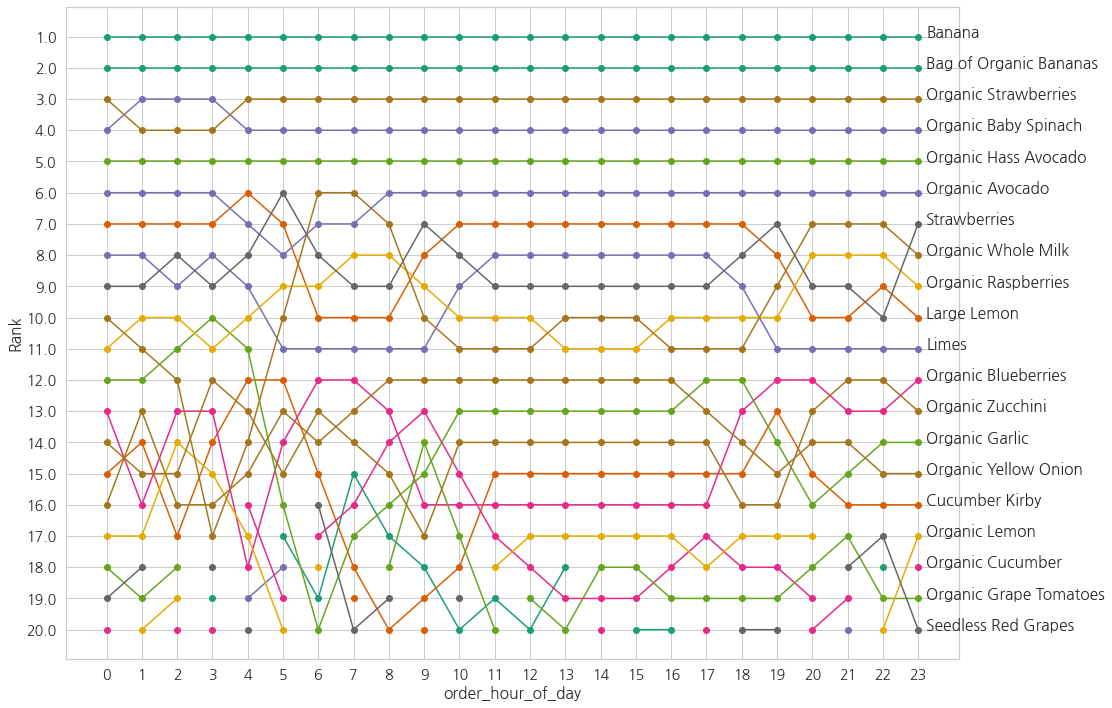

In [37]:
drawRankTrend(hour_top_product_pivot_ds)

##### Based on above graph:
There is a small change between organic strawberries and organic baby spinash for the first 3 hours but it remains consistent after those hours for the top 5 items throughout the day. 

For the rest of the items there is definitely change in their trend based on ranking for example: organic whole milk started at 10th place and ended in the 8th with a max rank of 6 and lowest been 17.

You can see that Working Hour (9H~17H) and other time patterns are very different.

### Shocase the Trending top 20 products based on the Day of the Week

In [38]:
rank_ds = order_products_prior.groupby(['product_name','order_dow'], as_index=False).agg({'order_id':len})
rank_ds = topItemEachGroup(rank_ds, 'order_dow', 'order_id' , 20)
rank_pivot_ds = rank_ds.pivot(index='order_dow', columns='product_name', values='rank')

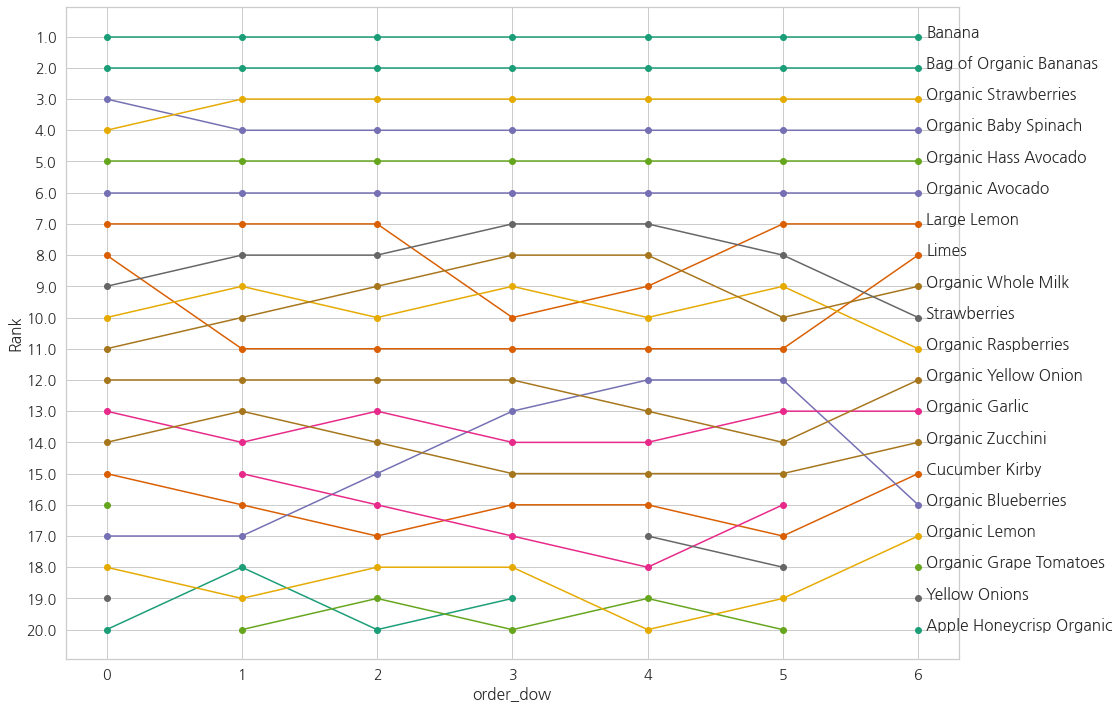

In [39]:
drawRankTrend(rank_pivot_ds)

##### Based on the previous graph shown:

the top 6 items barely change through out the week with the exception of the first day that organic strawberries and organic baby spinach change. This reiterates previous finding of both items changing at the beginning of the 24 hours

## In the next part we will be recommending a Product through Bundles

#### How does this Product Bunle work in order to recommend the customer what will they buy next?

Customers will add a product to their cart and we will offer them a recommendation list of items that are mostly matched with their added item to the cart based on previous parterns and similarity of products.

This will allow the customer select some products from the recommendation list without making them search for the product and if we are able to predict the right product bundles and offer relevant recommendations. This will improve the experience to customers in finding the right products while boosting sales and profits for the e-commerce

In [40]:
dataFrameList = []
index = 0
for row in order_products['products']:
    productsName = row.split(' ')
    tup = (index, productsName)
    dataFrameList.append(tup)
    index += 1

##### Randomly split data into train (70%) and test (30%)

In [41]:
random.shuffle(dataFrameList)

train_data = dataFrameList[:2250411]
test_data = dataFrameList[2250411:]

##### Spark dataframe： requires to read in chunks of 10000 items due to large quantity of  computation required

In [42]:
spark = SparkSession.builder.appName("Bigram").getOrCreate()

N = len(train_data)//10000
mod = len(train_data) % 10000
trainDF = spark.createDataFrame(dataFrameList[0:10000], ['id',"product_name"])

for i in range(1,N):
    trainDF_sub = spark.createDataFrame(train_data[10000*i:10000*(i+1)], ['id',"product_name"])
    traintDF = trainDF.union(trainDF_sub)
    
trainDF_sub = spark.createDataFrame(train_data[10000*N:len(train_data)], ['id',"product_name"])
trainDF = trainDF.union(trainDF_sub)

In [43]:
trainDF.head()

Row(id=1327155, product_name=['Organic_Mountain_Forest_Amber_Honey', 'Organic_Large_Grade_AA_Brown_Eggs', 'Organic_Reduced_Fat_Milk', 'Total_0%_Greek_Yogurt', 'Raw_Sauerkraut', 'Dijon_Honey_Mustard_Dressing', 'Poppy_Seed_Dressing', 'Whole_Wheat_Bunnies_Baked_Snack_Crackers', 'Organic_Cinnamon_Graham_Crackers', 'Organic_Baby_Spinach', "Organic_D'Anjou_Pears", 'Honeydew_Kombucha_Tea', 'Jasmine_Green', 'Rose_Black', 'Kombucha_Seasonal_Plum', 'Organic_Rolled_Oats', 'Organic_Dried_Granny_Apple_Chips', 'Organic_Fuji_Red_Apple_Chips', 'Unsweetened_Almondmilk', 'Oats_&_Honey_Gluten_Free_Granola', 'Maple_Pumpkin_Seeds_with_Sea_Salt_Chewy_with_a_Crunch_Granola_Bars', 'Gluten_Free_Dark_Chocolate_Chunk_Chewy_with_a_Crunch_Granola_Bars', 'Organic_Orzo', 'Organic_Whole_Wheat_Fusilli', 'Organic_Whole_Wheat_Elbows', 'Organic_Whole_Wheat_Penne_Rigate', 'Kids_Very_Emollient_Sunscreen_SPF_45', 'Very_Emollient_Fragrance_Free_Sunscreen_SPF_30'])

##### Creating a bigram that will show the name of two products that are bought consecutively

In [44]:
# get bigram data
ngram = NGram(n=2, inputCol="product_name", outputCol="bigrams")
ngramDataFrame = ngram.transform(trainDF)

ngramDataFrame.head()

Row(id=1327155, product_name=['Organic_Mountain_Forest_Amber_Honey', 'Organic_Large_Grade_AA_Brown_Eggs', 'Organic_Reduced_Fat_Milk', 'Total_0%_Greek_Yogurt', 'Raw_Sauerkraut', 'Dijon_Honey_Mustard_Dressing', 'Poppy_Seed_Dressing', 'Whole_Wheat_Bunnies_Baked_Snack_Crackers', 'Organic_Cinnamon_Graham_Crackers', 'Organic_Baby_Spinach', "Organic_D'Anjou_Pears", 'Honeydew_Kombucha_Tea', 'Jasmine_Green', 'Rose_Black', 'Kombucha_Seasonal_Plum', 'Organic_Rolled_Oats', 'Organic_Dried_Granny_Apple_Chips', 'Organic_Fuji_Red_Apple_Chips', 'Unsweetened_Almondmilk', 'Oats_&_Honey_Gluten_Free_Granola', 'Maple_Pumpkin_Seeds_with_Sea_Salt_Chewy_with_a_Crunch_Granola_Bars', 'Gluten_Free_Dark_Chocolate_Chunk_Chewy_with_a_Crunch_Granola_Bars', 'Organic_Orzo', 'Organic_Whole_Wheat_Fusilli', 'Organic_Whole_Wheat_Elbows', 'Organic_Whole_Wheat_Penne_Rigate', 'Kids_Very_Emollient_Sunscreen_SPF_45', 'Very_Emollient_Fragrance_Free_Sunscreen_SPF_30'], bigrams=['Organic_Mountain_Forest_Amber_Honey Organic_Large_G

##### After getting the bigrams, we count the frequency of each product

In [45]:
# count frequency:
# store bigram Bigrams in a nested dictionary:
# first layer is the first word found in the bigram 
# second layer is the second word found in the bigram which will show the frequency

bigrams = ngramDataFrame.toPandas()['bigrams']
table = {}
total = len(bigrams)
completion = 0
for bigram in bigrams:
    for combination in bigram:
        components = combination.split(' ')
        key = components[0]
        valKey = components[1]
        if key in table:
            valueDict = table[key]
            if valKey in valueDict:
                valueDict[valKey] = valueDict[valKey] + 1
            else:
                valueDict[valKey] = 1
        else:
            valueDict =  {valKey: 1}
            table[key] = valueDict
    completion += 1

### Show the most Popular Bundles
The popular bundle is generated by obtaining the combination of product that appear more than 20 times. Anything else is assumed to not be popular, this can always be changed depending on the threshold requested

In [46]:
# loop through the table to obtain the first and second items 
# as long as they appear over 20 times
for firstWord in table:
    for secondWord in table[firstWord]:
        if table[firstWord][secondWord] > 20:
            print(firstWord, " + ", secondWord, ": ", table[firstWord][secondWord])

Bag_of_Organic_Bananas  +  Organic_Hass_Avocado :  31
Bag_of_Organic_Bananas  +  Organic_Strawberries :  30
Organic_Raspberries  +  Organic_Strawberries :  25
Banana  +  Honeycrisp_Apple :  22
Banana  +  Organic_Fuji_Apple :  24
Banana  +  Organic_Strawberries :  33
Banana  +  Organic_Avocado :  40
Organic_Strawberries  +  Bag_of_Organic_Bananas :  27
Organic_Hass_Avocado  +  Bag_of_Organic_Bananas :  28
Organic_Avocado  +  Banana :  28
Sparkling_Water_Grapefruit  +  Lime_Sparkling_Water :  21


##### Given the previous product, generate a recommendation list, and predict the next product to be bought

In [47]:
def getPureData(prodName):
    
    '''
        return the corresponding product name by frequency in descending order
    '''
    
    if prodName not in table:
        return []
    sortedOringalList = sorted(table[prodName].items(), key=lambda x: x[1], reverse=True)
    data = {}
    for tp in sortedOringalList:
        product = tp[0]
        number = tp[1]
        if number in data:
            productList = data[number]
            productList.append(product)
        else:
            productList = [product]
        data[number] = productList
    pureData = data.values()
    return list(pureData)

def pickRecommendProds(pureData, numberOfRecommend):
    
    '''
        return recommended products based on the number of products requested
        and product name provided
    '''
    
    recommendProds = []
    for prods in pureData:
        if len(prods) <= numberOfRecommend:
            recommendProds += prods
            numberOfRecommend -= len(prods)
        else:
            recommendProds += random.sample(prods, numberOfRecommend)
            numberOfRecommend = 0

        if numberOfRecommend == 0:
            break
    
    return recommendProds

# Fucntion that returns recommended products previously bought with another item
def getRecommend(name, numberOfRecommend):
    
    recommendProducts = []
    productName = name
    index = 0

    while (numberOfRecommend):
        data = getPureData(productName)
        intermediate = pickRecommendProds(data, numberOfRecommend)
        recommendProducts += intermediate
        if len(intermediate) == 0 and index == len(recommendProducts):
            break
        numberOfRecommend -= len(intermediate)
        if numberOfRecommend > 0:
            productName = recommendProducts[index]
            index += 1

    return recommendProducts

##### In the following test we used "Bag of Organic Bananas" as previous product added to the cart and requested 15 items to be recommended in order to predict what the customer would buy

In [48]:
print(getRecommend("Bag_of_Organic_Bananas", 15))

['Organic_Hass_Avocado', 'Organic_Strawberries', 'Organic_Raspberries', 'Organic_Baby_Spinach', 'Organic_Blueberries', 'Organic_Large_Extra_Fancy_Fuji_Apple', 'Strawberries', 'Organic_Cucumber', 'Organic_Gala_Apples', 'Hass_Avocados', 'Organic_Avocado', 'Organic_Whole_Milk', 'Large_Lemon', 'Seedless_Red_Grapes', 'Organic_Navel_Orange']


### Checking how it performs on test data
We evaluate it by seeing in each order, how many products bought are in recommend list

In [49]:
# Function that returns test score based on the test data provided
def TestScore(test_data):
    
    scores = []

    for order_info in test_data:
        this_order = order_info[1]
        order_len = len(this_order)
        i = 0
        this_score = 0

        while (i < order_len):
            if this_order[i] in table:
                recommends = getRecommend(this_order[i], order_len)
                laterProds = this_order[i:]
                for prod in laterProds:
                    if prod in recommends:
                        this_score += 1
                i += 1
            else:
                i += 1
                order_len -= 1

        if not order_len == 0:
            scores.append(this_score/order_len)
        
    return(scores)

In [50]:
scores = TestScore(test_data)

In [51]:
print("======> Mean Test Scores: ", numpy.mean(scores))

======> Mean Test Scores:  0.182360534527946


### Conclusion:

from the test score we can conclude that 18% of the items predicted are been selected by the users when we use a Ranking model with Basket/product bundle.

If we consider the prediction for Bag of bananas. we can say that 18% of the 15 items recommended were picked. This means that 2.7 out of 15 items if rounded 2 or 3 items are picked from the recommended list for every order.

# Collaborative Filtering User-Item recommendation system

In [52]:
# Load products data
products = pd.read_csv('products.csv')

### Preprocessing Aisles and Departments dataset

In [53]:
# Replacing aisles with "missing" and "other"
# Replacing departments with "missing" and "other"

aisles = aisles[aisles["aisle"].apply(lambda x: x != "missing" and x != "other")]
departments = departments[departments["department"].apply(lambda x: x != "missing" and x != "other")]

### Creating functions that will be used later on

In [54]:
def get_user_list(df, user_column):
    """
    
    Creates the list of users with the user_column that comes 
    from the inputted dataframe
    
    """
    
    return np.sort(df[user_column].unique())

def get_item_list(df, item_name_column):
    
    """
    
    Creates a list of items, using item_name_column which contains 
    items form the given dataframe
    
    and then returns the item list
    
    """
    
    item_list = df[item_name_column].unique()
    
    
    return item_list

def get_feature_list(aisle_df, department_df, aisle_name_column, department_name_column):
    
    aisle = aisle_df[aisle_name_column]
    department = department_df[department_name_column]
    
    return pd.concat([aisle, department], ignore_index = True).unique()

# creating user_id, item_id, and features_id

def id_mappings(user_list, item_list, feature_list):
    """
    
    converting userId, itemId and featureId by mapping ids
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    
    # loop through user list and assign it to either 
    # user-index mapping or index-user mapping
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    
    # loop thorugh item list and assign it to either
    # item-index mapping or idex-item mapping
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        
    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    
    # loop thorugh feature list and assign it to either
    # feature-index mapping or idex-feature mapping
    for feature_index, feature_id in enumerate(feature_list):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id
        
        
    #return the data that was mapped
    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping


def get_user_product_interaction(orders_df, order_products_train_df, order_products_test_df, products_df):
    
    # create user-product df by merging product and user dataset for the trainig data
    user_to_product_train_df = orders_df[orders_df["eval_set"] == "prior"][["user_id", "order_id"]].\
    merge(order_products_train_df[["order_id", "product_id"]]).merge(products_df[["product_id", "product_name"]])\
    [["user_id", "product_name"]].copy()
    
    # rate product as number purchases goes up
    user_to_product_train_df["product_count"] = 1
    user_to_product_rating_train = user_to_product_train_df.groupby(["user_id", "product_name"], as_index = False)["product_count"].sum()
    
    # create user-product df by merging product 
    # and user dataset for the testing data
    user_to_product_test_df = orders_df[orders_df["eval_set"] == "train"][["user_id", "order_id"]].\
    merge(order_products_test_df[["order_id", "product_id"]]).merge(products_df[["product_id", "product_name"]])\
    [["user_id", "product_name"]].copy()
    
    # giving rating as the number of product purchase count
    # (including the previous purchase in the training data)
    user_to_product_test_df["product_count"] = 1
    user_to_product_rating_test = user_to_product_test_df.groupby(["user_id", "product_name"], as_index = False)["product_count"].sum()
    
    # Merge first df user-product train with test 
    user_to_product_rating_test = user_to_product_rating_test.\
    merge(user_to_product_rating_train.rename(columns = {"product_count" : "previous_product_count"}), how = "left").fillna(0)
    user_to_product_rating_test["product_count"] = user_to_product_rating_test.apply(lambda x: x["previous_product_count"] + \
                                                                                    x["product_count"], axis = 1)
    user_to_product_rating_test.drop(columns = ["previous_product_count"], inplace = True)
    
    # return user-product rating train and test
    return user_to_product_rating_train, user_to_product_rating_test

# this function returns the interaction matrix
def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

# this function returns the productFeature interaction dataframe
def get_product_feature_interaction(product_df, aisle_df, department_df, aisle_weight = 1, department_weight = 1):
    item_feature_df = product_df.merge(aisle_df).merge(department_df)[["product_name", "aisle", "department"]]
    
    item_feature_df["product_name"] = item_feature_df["product_name"]
    item_feature_df["aisle"] = item_feature_df["aisle"]
    item_feature_df["department"] = item_feature_df["department"]
    
    # fit aisle and departments under new column named feature
    product_aisle_df = item_feature_df[["product_name", "aisle"]].rename(columns = {"aisle" : "feature"})
    # adding weight to aisle feature
    product_aisle_df["feature_count"] = aisle_weight
    product_department_df = item_feature_df[["product_name", "department"]].rename(columns = {"department" : "feature"})
    product_department_df["feature_count"] = department_weight # adding weight to department feature
    
    # merge/concatinate product aisle and product department
    # while ignoring index
    product_feature_df = pd.concat([product_aisle_df, product_department_df], ignore_index=True)
    
    # This will allow the program to save memory and
    # not crash due to the amount of data been processed
    del item_feature_df
    del product_aisle_df
    del product_department_df
    
    # now we group the data and return the final result
    # grouping for summing over feature_count
    product_feature_df = product_feature_df.groupby(["product_name", "feature"], as_index = False)["feature_count"].sum()
    
    return product_feature_df

### Create the Lists for user, item and features. These lists will be needed in order to  recommend items based on user previously bought items

In [55]:
# create the user, item, feature lists
users = get_user_list(orders, "user_id")
users

array([     1,      2,      3, ..., 206207, 206208, 206209])

In [56]:
# get all products from item list and display the information
items = get_item_list(products, "product_name")
items

array(['Chocolate Sandwich Cookies', 'All-Seasons Salt',
       'Robust Golden Unsweetened Oolong Tea', ..., 'Artisan Baguette',
       'Smartblend Healthy Metabolism Dry Cat Food',
       'Fresh Foaming Cleanser'], dtype=object)

In [57]:
# get features from feature list and display the information
features = get_feature_list(aisles, departments, "aisle", "department")
features

array(['prepared soups salads', 'specialty cheeses',
       'energy granola bars', 'instant foods',
       'marinades meat preparation', 'packaged meat', 'bakery desserts',
       'pasta sauce', 'kitchen supplies', 'cold flu allergy',
       'fresh pasta', 'prepared meals', 'tofu meat alternatives',
       'packaged seafood', 'fresh herbs', 'baking ingredients',
       'bulk dried fruits vegetables', 'oils vinegars', 'oral hygiene',
       'packaged cheese', 'hair care', 'popcorn jerky', 'fresh fruits',
       'soap', 'coffee', 'beers coolers', 'red wines',
       'honeys syrups nectars', 'latino foods', 'refrigerated',
       'packaged produce', 'kosher foods', 'frozen meat seafood',
       'poultry counter', 'butter', 'ice cream ice', 'frozen meals',
       'seafood counter', 'dog food care', 'cat food care',
       'frozen vegan vegetarian', 'buns rolls', 'eye ear care',
       'candy chocolate', 'mint gum', 'vitamins supplements',
       'breakfast bars pastries', 'packaged poultry

### Map the features to index so we can use the LightFM library that requires integer index

In [58]:
# Generating the mapping through LightFM algo
# and it can only read integer indexes
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping = id_mappings(users, items, features)

### Display index-feature mapping

In [59]:
index_to_feature_mapping

{0: 'prepared soups salads',
 1: 'specialty cheeses',
 2: 'energy granola bars',
 3: 'instant foods',
 4: 'marinades meat preparation',
 5: 'packaged meat',
 6: 'bakery desserts',
 7: 'pasta sauce',
 8: 'kitchen supplies',
 9: 'cold flu allergy',
 10: 'fresh pasta',
 11: 'prepared meals',
 12: 'tofu meat alternatives',
 13: 'packaged seafood',
 14: 'fresh herbs',
 15: 'baking ingredients',
 16: 'bulk dried fruits vegetables',
 17: 'oils vinegars',
 18: 'oral hygiene',
 19: 'packaged cheese',
 20: 'hair care',
 21: 'popcorn jerky',
 22: 'fresh fruits',
 23: 'soap',
 24: 'coffee',
 25: 'beers coolers',
 26: 'red wines',
 27: 'honeys syrups nectars',
 28: 'latino foods',
 29: 'refrigerated',
 30: 'packaged produce',
 31: 'kosher foods',
 32: 'frozen meat seafood',
 33: 'poultry counter',
 34: 'butter',
 35: 'ice cream ice',
 36: 'frozen meals',
 37: 'seafood counter',
 38: 'dog food care',
 39: 'cat food care',
 40: 'frozen vegan vegetarian',
 41: 'buns rolls',
 42: 'eye ear care',
 43: '

### Evaluate the data of how many times a product was ordered by a user in train and test set

In [60]:
# Convert all the lists into indexes in order to read
# the indexes of the matrices
user_to_product_rating_train, user_to_product_rating_test = get_user_product_interaction(orders, order_products_prior, 
                                                                                        order_products_train, products)

In [61]:
# Display the user-product rating train set
user_to_product_rating_train.head()

,user_id,product_name,product_count
0,1,0% Greek Strained Yogurt,1
1,1,Aged White Cheddar Popcorn,2
2,1,Bag of Organic Bananas,2
3,1,Bartlett Pears,1
4,1,Cinnamon Toast Crunch,3


In [62]:
# Display the user-product rating test set
user_to_product_rating_test.head()

,user_id,product_name,product_count
0,1,0% Greek Strained Yogurt,2.0
1,1,Aged White Cheddar Popcorn,3.0
2,1,Cinnamon Toast Crunch,4.0
3,1,Milk Chocolate Almonds,2.0
4,1,Organic Half & Half,3.0


### After evaluating the data we create different matrices.

 - Product-Feature Matrix:  This will allow to know how many type a certain product was ordered and feature it is(type of product)
 - User-Product Matrix (Train & Test): This will obtain the relationship between user and product in the train and test set

In [63]:
# create product-feature matrix
product_to_feature = get_product_feature_interaction(product_df = products, 
                                                     aisle_df = aisles, 
                                                     department_df = departments,
                                                     aisle_weight=1, 
                                                     department_weight=1)

In [64]:
# Display product-feature matrix
product_to_feature.head()

,product_name,feature,feature_count
0,#2 Coffee Filters,beverages,1
1,#2 Coffee Filters,coffee,1
2,#2 Cone White Coffee Filters,beverages,1
3,#2 Cone White Coffee Filters,coffee,1
4,#2 Mechanical Pencils,household,1


In [65]:
# create user-item matrix for training data
user_to_product_interaction_train = get_interaction_matrix(user_to_product_rating_train, "user_id", 
                                                    "product_name", "product_count", user_to_index_mapping, item_to_index_mapping)

# create user-item matrix for testing data
user_to_product_interaction_test = get_interaction_matrix(user_to_product_rating_test, "user_id", 
                                                    "product_name", "product_count", user_to_index_mapping, item_to_index_mapping)

# create item-feature interaction
product_to_feature_interaction = get_interaction_matrix(product_to_feature, "product_name", "feature",  "feature_count", 
                                                        item_to_index_mapping, feature_to_index_mapping)

In [66]:
user_to_product_interaction_train

<206209x49688 sparse matrix of type '<class 'numpy.int64'>'
	with 13307953 stored elements in COOrdinate format>

In [67]:
user_to_product_interaction_test

<206209x49688 sparse matrix of type '<class 'numpy.float64'>'
	with 1384617 stored elements in COOrdinate format>

In [68]:
product_to_feature_interaction

<49688x151 sparse matrix of type '<class 'numpy.int64'>'
	with 95764 stored elements in COOrdinate format>

# Implementing LightFM Cross Validation

### using pure collaborative filtering, not adding some item features as consideration

In [69]:
# initialization of model through the warp function
model_without_features = LightFM(loss = "warp")

In [70]:
# fit user-product matrix, this is only done through a pure collaborative filtering factor

start = time.time()
#===================

model_without_features.fit(user_to_product_interaction_train,
          user_features=None, 
          item_features=None, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 9.11 seconds


In [71]:
# AUC metric score ranges from 0 to 1

start = time.time()
#===================

auc_without_features = auc_score(model = model_without_features, 
                        test_interactions = user_to_product_interaction_test,
                        num_threads = 4, check_intersections = False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 115.97 seconds


In [72]:
print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_without_features.mean(), 2))

average AUC without adding item-feature interaction = 0.95


#### After modeling the data through LightFM algo without features we found out that it's average AUC is 0.95 as shown in the above code

### This time we will include item features and see if it increases or reduces the AUC

In [73]:
# we do another initialization of model through the warp function
model_with_features = LightFM(loss = "warp")

In [74]:
# fit the model but this time using a hybrid collaborative filtering 
# and content based (product + features)
start = time.time()
#===================


model_with_features.fit(user_to_product_interaction_train,
          user_features=None, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 11.79 seconds


In [75]:
start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features, 
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train, 
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 162.75 seconds


In [76]:
print("average AUC with adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))

average AUC with adding item-feature interaction = 0.80


#### After modeling the data through LightFM algo with features we found out that it's average AUC is 0.80 reducing its accuracy from previous modeling when not using features

### Requesting Products / Items Recommendation

##### We now need to retrain the model because we will be combining train and test set for the next part

In [77]:
def combined_train_test(train, test):
    """
    
    Combine the follwoing sets
        training: contains previous number of order with rating by user
        testing: contains most recent number of order with rating by user
    
    """
    # initialize and asign train dictionary
    train_dict = {}
    for train_row, train_col, train_data in zip(train.row, train.col, train.data):
        train_dict[(train_row, train_col)] = train_data
        
    # replaces data with test data set
    
    for test_row, test_col, test_data in zip(test.row, test.col, test.data):
        train_dict[(test_row, test_col)] = max(test_data, train_dict.get((test_row, test_col), 0))
        
    
    # convert row, column and data elements to element array
    row_element = []
    col_element = []
    data_element = []
    for row, col in train_dict:
        row_element.append(row)
        col_element.append(col)
        data_element.append(train_dict[(row, col)])
        
    # convert elements to np array
    row_element = np.array(row_element)
    col_element = np.array(col_element)
    data_element = np.array(data_element)
    
    # return final data
    return coo_matrix((data_element, (row_element, col_element)), shape = (train.shape[0], train.shape[1]))

In [78]:
# Combining train and test user-product interaction
user_to_product_interaction = combined_train_test(user_to_product_interaction_train, 
                                                 user_to_product_interaction_test)

In [79]:
user_to_product_interaction

<206209x49688 sparse matrix of type '<class 'numpy.float64'>'
	with 13863746 stored elements in COOrdinate format>

In [80]:
# now we retrain the model

final_model = LightFM(loss = "warp")

start = time.time()
#===================

final_model.fit(user_to_product_interaction,
          user_features=None, 
          item_features=None, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 9.35 seconds


### Creating class that contains functions in order to predict the recommendation based on user

the prediction will be based on previous matrix mentioned such as user-product matrix

In [81]:
class recommendation_sampling:
    
    def __init__(self, model, items = items, user_to_product_interaction_matrix = user_to_product_interaction, 
                user2index_map = user_to_index_mapping):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
    
    def recommendation_for_user(self, user):
        
        # get user index
        
        userindex = self.user2index_map.get(user, None)
        
        if userindex == None:
            return None
        
        users = [userindex]
        
        # get purchased products
        
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # get score from predicted model
        scores = self.model.predict(user_ids = users, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]))
        
        # retrieve top scoring items
        
        top_items = self.items[np.argsort(-scores)]
        
        print("User %s" % user)
        print("     Known positives:")
        
        for x in known_positives[:10]:
            print("                  %s" % x)
            
            
        print("     Recommended:")
        
        for x in top_items[:10]:
            print("                  %s" % x)

In [82]:
# get recommended item list
recom = recommendation_sampling(model = final_model)

### Display the Recommendated products for user 6 and user 30 (sample)

In [83]:
recom.recommendation_for_user(6)

User 6
     Known positives:
                  Broccoli Crown
                  Italian Extra Virgin Olive Oil
                  Medium Cheddar Cheese Block
                  Strained Tomatoes
                  Organic Baby Spinach
                  Organic Coconut Milk
                  Organic Lacinato (Dinosaur) Kale
                  Ground Turkey Breast
                  Chopped Tomatoes
                  Organic Zucchini
     Recommended:
                  Organic Strawberries
                  Banana
                  Organic Baby Spinach
                  Bag of Organic Bananas
                  Limes
                  Organic Avocado
                  Organic Hass Avocado
                  Large Lemon
                  Organic Yellow Onion
                  Organic Garlic


In [97]:
recom.recommendation_for_user(30)

User 30
     Known positives:
                  Clementines
                  Smartwater
                  Distilled Water
                  49 Flavors Jelly Belly Jelly Beans
                  Tall Kitchen Bag With Febreze Odor Shield
                  Milk Chocolate M&Ms
     Recommended:
                  Bag of Organic Bananas
                  Organic Strawberries
                  Organic Baby Spinach
                  Strawberries
                  Raspberries
                  Organic Blueberries
                  Hass Avocados
                  Banana
                  Clementines
                  Organic Baby Carrots


### Conclusion:

As shown in the 2 tested predictions for user 6 and 30. we have found some predicted products that were bought by the consumer.

For example, for user 6 we can see that our model was able to predict "Organic Baby Spinash" and for user 30 it was able to predict "Clementines".

This shows that at least 1 out of 10 items are been picked by users from the recommended list predicted by our model.

In addition, the AUC is 95%. this shows that is very accurate but it has a slow performance due to the amount of data been processed and resources that it uses which is over 8GB